# Electricity production in the OECD countries in 2010-2022

![bulb_image](bulb_image_.jpg)

## Table of Contents: * <a id="contents"></a>

- [Goals](#goals)
- [Data](#data)
    - [Loading the data](#data_loading)
    - [Data information](#data_information)
    - [Data cleaning](#data_cleaning)
- [Exploratory Data Analysis](#eda)
    - [Total electricity production in OECD countries](#eda_1)
    - [Is electricity production in OECD countries seasonal? How did monthly electricity production changed over time?](#eda_2)
    - [Proportions for different energy sources in the OECD total electricity production](#eda_3)
    - [Top-5 energy sources in each OECD region in 2022](#eda_4)
    - [Changes in total low-carbon electricity production](#eda_5)
    - [Percentage of low-carbon power generation in each OECD region](#eda_6)
    - [Top-10 countries that produced the largest amount of electricity in 2022](#eda_7)
    - [For each energy source, top-5 countries that produced the largest amount of electricity in 2022](#eda_8)
    - [Correlation between GDP per capita (in current US Dollars) and low-carbon electricity production share](#eda_9)
    - [Distribution of low-carbon electricity production share by GDP quartiles](#eda_10)
- [Conclusion](#conclusion)

\* **_Note_**: due to GitHub limitations, internal links in the Table of Contents do not work. To access Jupyter Notebook with all internal links working, please click here [nbviewer Jupyter Notebook viewer service](https://nbviewer.org/github/teona-pavliukova/OECD-Electricity-Production/blob/master/oecd_countries_electricity_production.ipynb#eda)

## Goals
<a id="goals"></a>

[(Back to Table of Contents)](#contents)

The OECD is the Organisation for Economic Co-operation and Development. This notebook contains an analysis on electricity production in the 37 OECD countries and 10 non-OECD economies in 2010-2022.

The goal for this project was to do the following:
* Get acquainted with the data
* Clean the data as required for the analysis
* Develop some questions for analysis
* Analyze variables within the data to gain patterns and insights on these questions

## Data <a id="data"></a>

[(Back to Table of Contents)](#contents)

The data with monthly **electricity production in the OECD countries** was downloaded from Kaggle: [https://www.kaggle.com/datasets/ccanb23/iea-monthly-electricity-statistics](https://www.kaggle.com/datasets/ccanb23/iea-monthly-electricity-statistics). Information regarding the features for the data is located in the **Column** section on the website.

**Dataset dictionary** can be accessed on the [iea.org](https://www.iea.org/data-and-statistics/data-product/monthly-electricity-statistics#documentation) website.

The data with **GDP per capita** was downloaded from [The World Bank](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD) website.

### Loading the Data <a id="data_loading"></a>

[(Back to Table of Contents)](#contents)

Firstly, the necessary libraries are loaded into the notebook.

The pandas library is used to import data from `monthly_electricity_production.csv`.

In [245]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [246]:
# load data and have a look into first 5 rows
data = pd.read_csv('monthly_electricity_production.csv')
data.head()

,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
0,Australia,JAN2010,January 2010,2010,1,January,Hydro,990.728,1,16471.891,NaN,0.047771
1,Australia,JAN2010,January 2010,2010,1,January,Wind,409.469,2,4940.909,NaN,0.019744
2,Australia,JAN2010,January 2010,2010,1,January,Solar,49.216,3,908.238,NaN,0.002373
3,Australia,JAN2010,January 2010,2010,1,January,Geothermal,0.083,4,0.996,NaN,0.000004
4,Australia,JAN2010,January 2010,2010,1,January,Total combustible fuels,19289.730,7,214302.969,NaN,0.930108


### Data Information <a id="data_information"></a>

[(Back to Table of Contents)](#contents)

Some immediate insights about the data:
* There are 12 columns and 181915 rows in the initial dataset
* Data types: 4 columns contain floats, 3 columns - integers, remaining 5 - objects (most likely strings).
* Some columns with the information not relevant for the intended analyses can be removed from the dataset to free up some space, namely: *'DISPLAY_ORDER'*, *'yearToDate'*, *'previousYearToDate'*, *'share'*
* Column names are inconsistent and will require renaming for more consistency.
* Only *'previousYearToDate'* column has missing values which won't be an issue since this column would be removed from the dataset as described above

In [247]:
# check data shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181915 entries, 0 to 181914
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COUNTRY             181915 non-null  object 
 1   CODE_TIME           181915 non-null  object 
 2   TIME                181915 non-null  object 
 3   YEAR                181915 non-null  int64  
 4   MONTH               181915 non-null  int64  
 5   MONTH_NAME          181915 non-null  object 
 6   PRODUCT             181915 non-null  object 
 7   VALUE               181915 non-null  float64
 8   DISPLAY_ORDER       181915 non-null  int64  
 9   yearToDate          181915 non-null  float64
 10  previousYearToDate  164810 non-null  float64
 11  share               181915 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 16.7+ MB


In [248]:
# check null values
data.isnull().sum()

COUNTRY                   0
CODE_TIME                 0
TIME                      0
YEAR                      0
MONTH                     0
MONTH_NAME                0
PRODUCT                   0
VALUE                     0
DISPLAY_ORDER             0
yearToDate                0
previousYearToDate    17105
share                     0
dtype: int64

### Data Cleaning <a id="data_cleaning"></a>

[(Back to Table of Contents)](#contents)

Data cleaning for this dataset included the following steps:

1. Removing irrelevant columns.

    After removal, the dataset has 8 columns: 1 column contains floats, 2 - integers, and remaining 5 - objects (most likely strings). No remaining columns have any missing data.

2. Renaming all column names to lowercase for consistency.

3. Convert year, month and day columns to datetime and set the day to MonthEnd. This will enable us to investigate time series data in the EDA section. Columns that are no longer required are dropped for ease.

4. Looking into basic summary statistics on each of the numerical variables for suspicious values. 

    Only one column has suspicious values: *'value'* column has negative values which does look suspicious as the amount of generated electricity is supposed to be a positive number. Further investigation showed that the data have negative values only for 4 unique *products*: 'Electricity trade', 'Used for pumped storage', 'Distribution losses', and 'Oil'.

    Out of these 4 products only 'Oil' is an actual energy source and might be an issue in further analysis. Filtering data for negative values in the dataset for 'Oil' product showed only 1 row for France in August 2017. Remaining 3 products with negative values won't have difference for the analysis as they are not actual energy sources and will be removed from the dataset regardless of the values. For consistency, all rows with negative numbers in *'value'* column were removed from the dataset.

5. Looking into values for *'product'* column and removing all values that are not actual energy sources

6. Looking into values for *'country'* column.

    This column has both individual countries and regional groups. As mentioned in the *Dataset dictionary*, the units in the dataset are terawatt hours (TWh) for the regional groups and gigawatt hours (GWh) for the individual countries. It will make sense to split the dataset into separate datasets for individual countries and regions. Also, IEA Total largely repeats the OECD Total with the exception of 4 countries, so this region will be removed from the regions dataset.

In [249]:
# drop irrelevant columns
data.drop(['DISPLAY_ORDER', 'yearToDate', 'previousYearToDate', 'share'], inplace=True, axis='columns')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181915 entries, 0 to 181914
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   COUNTRY     181915 non-null  object 
 1   CODE_TIME   181915 non-null  object 
 2   TIME        181915 non-null  object 
 3   YEAR        181915 non-null  int64  
 4   MONTH       181915 non-null  int64  
 5   MONTH_NAME  181915 non-null  object 
 6   PRODUCT     181915 non-null  object 
 7   VALUE       181915 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 11.1+ MB


In [250]:
# change column names to lower case
columns_lower = [name.lower() for name in data.columns]
data.columns = columns_lower
data.head()

,country,code_time,time,year,month,month_name,product,value
0,Australia,JAN2010,January 2010,2010,1,January,Hydro,990.728
1,Australia,JAN2010,January 2010,2010,1,January,Wind,409.469
2,Australia,JAN2010,January 2010,2010,1,January,Solar,49.216
3,Australia,JAN2010,January 2010,2010,1,January,Geothermal,0.083
4,Australia,JAN2010,January 2010,2010,1,January,Total combustible fuels,19289.730


In [251]:
# load MonthEnd offset from pandas package to convert dates to the end of month
from pandas.tseries.offsets import MonthEnd

# add 'day' column with 1 value for each row. This is required for the subsequent pandas to_datetime function
data['day'] = 1

In [252]:
# convert year, month and day columns to datetime and set the day to MonthEnd
data['date'] = pd.to_datetime(data[['year', 'month', 'day']], format="%Y%m%d") + MonthEnd(0)
# drop columns that are no longer required
months_list = list(data['month_name'].unique())
months_list = months_list = [x[:3] for x in months_list]
data.drop(['code_time', 'time', 'month_name', 'day'], axis=1, inplace=True)
data.head(5)

,country,year,month,product,value,date
0,Australia,2010,1,Hydro,990.728,2010-01-31
1,Australia,2010,1,Wind,409.469,2010-01-31
2,Australia,2010,1,Solar,49.216,2010-01-31
3,Australia,2010,1,Geothermal,0.083,2010-01-31
4,Australia,2010,1,Total combustible fuels,19289.730,2010-01-31


In [253]:
# descriptive summary statistics to check for suspicious values
data.describe()

,year,month,value
count,181915.000000,181915.000000,1.819150e+05
mean,2016.456818,6.498145,2.091292e+04
std,3.657532,3.452288,8.584724e+04
min,2010.000000,1.000000,-6.852344e+03
25%,2013.000000,3.000000,6.685189e+01
50%,2017.000000,6.000000,7.663990e+02
75%,2020.000000,9.000000,4.989495e+03
max,2022.000000,12.000000,1.001529e+06


In [254]:
# investigate further suspicious negative values - print unique products
print(f"Unique products with negative values: {data[data['value'] < 0]['product'].unique()}\n")
# print rows with negative electricity production for oil 
print(f"Rows with negative electricity production for Oil: \n{data[(data['product'] == 'Oil') & (data['value'] < 0)]}\n")
# remove negative values from the dataset
data = data[data['value'] > 0]
data.describe()


Unique products with negative values: ['Electricity trade' 'Used for pumped storage' 'Distribution losses' 'Oil']

Rows with negative electricity production for Oil: 
      country  year  month product  value       date
96034  France  2017      8     Oil -19.22 2017-08-31



,year,month,value
count,164842.000000,164842.000000,1.648420e+05
mean,2016.312748,6.498617,2.309884e+04
std,3.678306,3.451902,8.990049e+04
min,2010.000000,1.000000,9.000000e-06
25%,2013.000000,3.000000,1.672939e+02
50%,2016.000000,6.000000,1.092168e+03
75%,2019.000000,9.000000,6.115303e+03
max,2022.000000,12.000000,1.001529e+06


In [255]:
# look into unique values for product columns.
print(list(data['product'].unique()))

['Hydro', 'Wind', 'Solar', 'Geothermal', 'Total combustible fuels', 'Coal', 'Oil', 'Natural gas', 'Combustible renewables', 'Net electricity production', 'Electricity supplied', 'Used for pumped storage', 'Distribution losses', 'Final consumption', 'Renewables', 'Non-renewables', 'Others', 'Other renewables aggregated', 'Low carbon', 'Fossil fuels', 'Other combustible non-renewables', 'Not specified', 'Total imports', 'Total exports', 'Nuclear', 'Other renewables', 'Electricity trade']


In [256]:
# some values in 'product' are aggregates for groups and some are not actual sources at all. Removing irrelevant products from the dataset
generation_sources = ['Coal', 'Combustible renewables', 'Geothermal', 'Hydro', 'Natural gas', 'Nuclear', 'Oil',
                      'Other combustible non-renewables', 'Solar', 'Wind']
data = data[data['product'].isin(generation_sources) == True]
# check that the 'product' column contains only correct values
print(list(data['product'].unique()))

['Hydro', 'Wind', 'Solar', 'Geothermal', 'Coal', 'Oil', 'Natural gas', 'Combustible renewables', 'Other combustible non-renewables', 'Nuclear']


In [257]:
# look into unique values for 'country' column
print(list(data['country'].unique()))

['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'IEA Total', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'OECD Americas', 'OECD Asia Oceania', 'OECD Europe', 'OECD Total', 'Poland', 'Portugal', 'Republic of Turkiye', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States', 'Colombia', 'Argentina', 'Brazil', 'Bulgaria', 'Croatia', 'Cyprus', 'India', 'Malta', 'North Macedonia', 'Romania', 'Serbia', 'Costa Rica']


In [258]:
# split dataset for individual countries and regions. Remove 'IEA Total' from regions dataset
regions = ['IEA Total', 'OECD Americas', 'OECD Asia Oceania', 'OECD Europe', 'OECD Total']
data_regions = data[data['country'].isin(regions) == True]
data_regions = data_regions[data_regions['country'] != 'IEA Total']
data_countries = data[data['country'].isin(regions) == False]
# check if unique values for 'country' column for both datasets are correct
print(list(data_regions['country'].unique()))
print(list(data_countries['country'].unique()))

['OECD Americas', 'OECD Asia Oceania', 'OECD Europe', 'OECD Total']
['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Republic of Turkiye', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States', 'Colombia', 'Argentina', 'Brazil', 'Bulgaria', 'Croatia', 'Cyprus', 'India', 'Malta', 'North Macedonia', 'Romania', 'Serbia', 'Costa Rica']


## Exploratory Data Analysis <a id="eda"></a>

[(Back to Table of Contents)](#contents)

After some data cleaning and tidying, the DataFrame is ready for EDA. 

The hope is that through summary statistics and visualizations the following question can be answered:

1. How total electricity production in OECD countries changed over the years 2010-2022? [link](#eda_1)
2. Is electricity production in OECD countries seasonal? How did monthly electricity production changed over time? [link](#eda_2)
3. What are the proportions for different energy sources in the OECD total electricity productions? How did they change over the period 2010-2022? [link](#eda_3)
4. What were the top-5 energy sources in each OECD region in 2022? [link](#eda_4)
5. How did the total low-carbon electricity production in OECD countries change in 2010-2022 period? [link](#eda_5)
6. What is the proportion of low-carbon power generation in OECD regions? How did it change over 2010-2022 period? Did all regions have the same pattern? [link](#eda_6)
7. What are the top-10 countries that produced the largest amount of electricity in 2022? In which OECD regions are they located? [link](#eda_7)
8. For each energy source, which top-5 countries produced the largest amount of electricity in 2022? [link](#eda_8)
9. Is there a correlation between GDP per capita (in current US Dollars) and low-carbon electricity production share? [link](#eda_9)
10. Distribution of low-carbon electricity production share by GDP quartiles [link](#eda_10)

### 1. How total electricity production in OECD countries changed over the years 2010-2022 <a id="eda_1"></a>

[(Back to Table of Contents)](#contents)

To investigate how total electricity production changed over the years, for each year I will look into the changes (%) from previous year's production (first graph) and from the baseline production in 2010 (~ 10.4M TWh, second graph).

The first chart shows that if looking into **_changes from previous year's production_**, there were 5 years when production decreased (2011, 2012, 2013, 2019 and 2020) with the largest drop in 2019 and 2020 (-1.4% and -2.6% from previous years respectively). In the remaining 7 years the electricity production increased, with the highest rises in 2018 and 2021 (1.9% and 3.1% respectively).

The second chart shows that if we look into **_changes from baseline 2010 production_**, there were 4 years when total production was below the baseline (2011, 2012, 2013 and 2020) with the largest drop in 2020 (-0.6% from baseline production). In the remaining 8 years the electricity production increased, with the highest rises in 2018, 2021 and 2022 years (3.5%, 2.5% and 3.6% respectively).

In [259]:
# group data by regions and years and calculate total electricity production
data_regions_totals = data_regions.groupby(['country', 'year'])['value'].sum().reset_index()
# save totals for 'OECD Total' into a separate DataFrame data_regions_grand_total
data_regions_grand_total = data_regions_totals[data_regions_totals['country'] == 'OECD Total'].reset_index(drop=True)
data_regions_grand_total.columns = ['region', 'year', 'total']
data_regions_grand_total.head()

,region,year,total
0,OECD Total,2010,1.039544e+07
1,OECD Total,2011,1.036570e+07
2,OECD Total,2012,1.035936e+07
3,OECD Total,2013,1.035631e+07
4,OECD Total,2014,1.040085e+07


In [260]:
# calculate percent of change in total production from previous year production
data_regions_grand_total['perc_change_prev_year'] = round(data_regions_grand_total['total'].diff()/data_regions_grand_total['total'].\
                                                    shift(1)*100, 1)
# set value to percent of change for 2010
data_regions_grand_total['perc_change_prev_year'].fillna(0, inplace=True)

In [261]:
# set amount produced in 2010 as a baseline
baseline_grand_total = data_regions_grand_total[data_regions_grand_total['year'] == 2010]['total'].item()

# calculate percent of change from baseline for each year
data_regions_grand_total['perc_change_from_2010'] = round((data_regions_grand_total['total'] - baseline_grand_total)/baseline_grand_total*100, 1)
data_regions_grand_total

,region,year,total,perc_change_prev_year,perc_change_from_2010
0,OECD Total,2010,1.039544e+07,0.0,0.0
1,OECD Total,2011,1.036570e+07,-0.3,-0.3
2,OECD Total,2012,1.035936e+07,-0.1,-0.3
3,OECD Total,2013,1.035631e+07,-0.0,-0.4
4,OECD Total,2014,1.040085e+07,0.4,0.1
5,OECD Total,2015,1.044917e+07,0.5,0.5
6,OECD Total,2016,1.052072e+07,0.7,1.2
7,OECD Total,2017,1.055758e+07,0.4,1.6
8,OECD Total,2018,1.075972e+07,1.9,3.5
9,OECD Total,2019,1.061161e+07,-1.4,2.1


In [262]:
# separate positive and negative changes into separate subsets for color differentiation
# for previous year changes
data_regions_grand_total_py_pos = data_regions_grand_total[data_regions_grand_total['perc_change_prev_year'] >= 0]
data_regions_grand_total_py_neg = data_regions_grand_total[data_regions_grand_total['perc_change_prev_year'] < 0]
# for baseline changes
data_regions_grand_total_bl_pos = data_regions_grand_total[data_regions_grand_total['perc_change_from_2010'] >= 0]
data_regions_grand_total_bl_neg = data_regions_grand_total[data_regions_grand_total['perc_change_from_2010'] < 0]

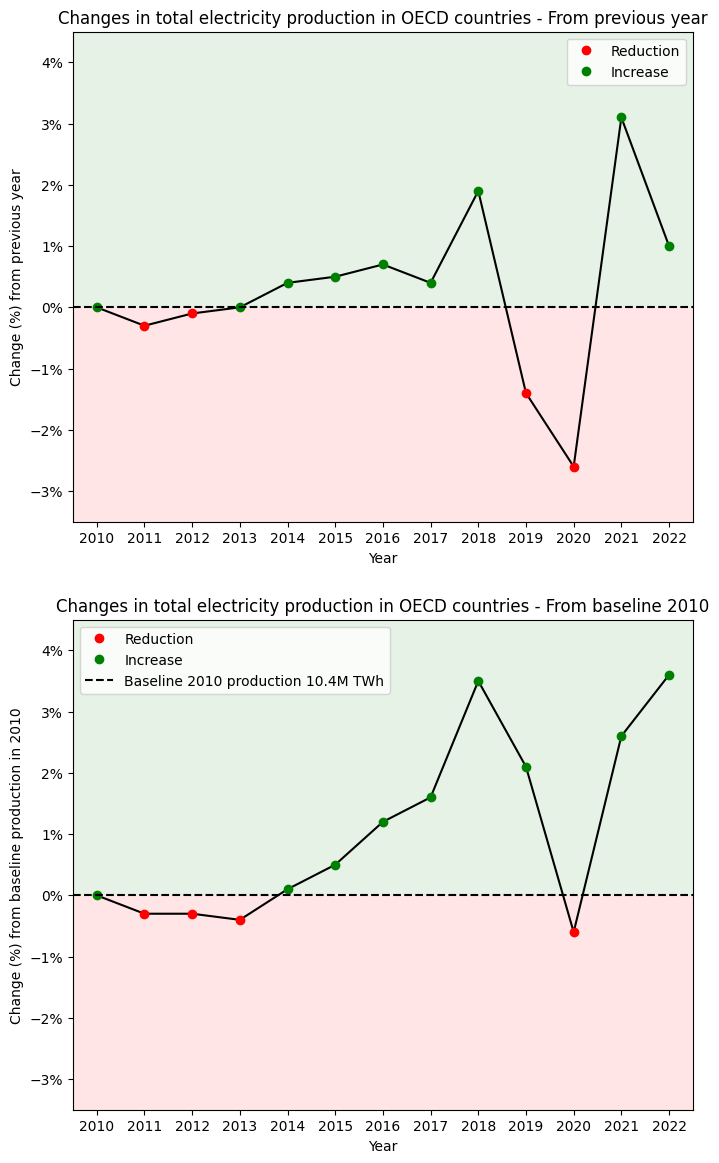

<Figure size 640x480 with 0 Axes>

In [263]:
# plot changes in total electricity production
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 14), sharey=True)

# plot line chart of changes from previous year
ax1.plot(data_regions_grand_total['year'], data_regions_grand_total['perc_change_prev_year'], color='black')
ax1.plot(data_regions_grand_total_py_neg['year'], data_regions_grand_total_py_neg['perc_change_prev_year'],
         color='red', marker='o', linestyle='None', label='Reduction')
ax1.plot(data_regions_grand_total_py_pos['year'], data_regions_grand_total_py_pos['perc_change_prev_year'],
         color='green', marker='o', linestyle='None', label='Increase')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_ylim(-3.5, 4.5)
ax1.set_xlim(2009.5, 2022.5)
ax1.fill_between((2009.5, 2022.5), 0, 4.5, facecolor='green', alpha=0.1)
ax1.fill_between((2009.5, 2022.5), -3.5, 0, facecolor='red', alpha=0.1)
ax1.set_xticks(ticks=range(2010, 2023))
ax1.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=0))
ax1.legend()
ax1.set(title='Changes in total electricity production in OECD countries - From previous year',
        xlabel='Year', ylabel='Change (%) from previous year')

# plot line chart of changes from baseline 2010
ax2.plot(data_regions_grand_total['year'], data_regions_grand_total['perc_change_from_2010'], color='black')
ax2.plot(data_regions_grand_total_bl_neg['year'], data_regions_grand_total_bl_neg['perc_change_from_2010'],
         color='red', marker='o', linestyle='None', label='Reduction')
ax2.plot(data_regions_grand_total_bl_pos['year'], data_regions_grand_total_bl_pos['perc_change_from_2010'],
         color='green', marker='o', linestyle='None', label='Increase')
ax2.axhline(0, color='black', label='Baseline 2010 production 10.4M TWh', linestyle='--')
ax2.set_xlim(2009.5, 2022.5)
ax2.fill_between((2009.5, 2022.5), 0, 4.5, facecolor='green', alpha=0.1)
ax2.fill_between((2009.5, 2022.5), -3.5, 0, facecolor='red', alpha=0.1)
ax2.set_xticks(ticks=range(2010, 2023))
ax2.legend()
ax2.set(title='Changes in total electricity production in OECD countries - From baseline 2010',
        xlabel='Year', ylabel='Change (%) from baseline production in 2010')
plt.show()
plt.clf()

<a id="eda_2"></a>

### 2. Is electricity production in OECD countries seasonal? How did monthly electricity production changed over time?

[(Back to Table of Contents)](#contents)

As can be seen on the first chart, *monthly electricity production in OECD countries* seems to be seasonal with regular picks and drops with no significant growth trend over time.

Heatmap on second visual helps to identify *distinctive patterns in electricity production*: we can see sharp increases in Dec-Jan and Jul-Aug periods and distinctive declines in Apr-May and Oct-Nov periods consistently every year. It's worth noting that Apr 2010, and Apr and May of 2020 were the months with the lowest electricity production; Jan of 2018 and Jan of 2022 were two months with the highest electricity production.

Third visual shows *boxplots of monthly electricity production for each year*. There are no outliers which indicates that there were no months with dramatically lower/higher electricity production. Boxplots for 2010 has longest lower whisker, shortest top whisker and smallest median which all show that monthly electricity production was lower for this year when compared with other years.

Next step is to investigate if elements of our times series are *positively/negatively correlated or independent of each other*. This can be done with the help of `.autocorrelation_plot()` function of the `pandas.plotting` module - this plot is presented on visual 4, lag is on x-axis and the value of auto-correlation is on y-axis. The closer the value is to -1 or 1, the stronger the correlation. The autocorrelation plot for the monthly electricity production forms distinctive waves, oscillating between strong positive and strong negative correlation which proves our previous findings that our dataset exhibits seasonality. Autocorrelation decreases over time, indicating that electricity production from previous years is less associated with more recent monthly production.


In [264]:
# save data for OECD Total into a separate df
data_oecd = data_regions[data_regions['country'] == 'OECD Total'].reset_index(drop=True)
data_oecd.head()

,country,year,month,product,value,date
0,OECD Total,2010,1,Hydro,131431.410,2010-01-31
1,OECD Total,2010,1,Wind,21684.883,2010-01-31
2,OECD Total,2010,1,Solar,1129.450,2010-01-31
3,OECD Total,2010,1,Geothermal,3356.901,2010-01-31
4,OECD Total,2010,1,Nuclear,200623.300,2010-01-31


In [265]:
# calculate total electricity production for each month
data_oecd_t_monthly = data_oecd.groupby(['date', 'year', 'month']).sum(numeric_only=True).round(0).reset_index()
data_oecd_t_monthly.head()

,date,year,month,value
0,2010-01-31,2010,1,949287.0
1,2010-02-28,2010,2,846061.0
2,2010-03-31,2010,3,859380.0
3,2010-04-30,2010,4,771399.0
4,2010-05-31,2010,5,811275.0


In [266]:
# calculate total electricity production in millions of TWh
data_oecd_t_monthly['value_m'] = round(data_oecd_t_monthly['value'] / 1000000, 2)
data_oecd_t_monthly.head()

,date,year,month,value,value_m
0,2010-01-31,2010,1,949287.0,0.95
1,2010-02-28,2010,2,846061.0,0.85
2,2010-03-31,2010,3,859380.0,0.86
3,2010-04-30,2010,4,771399.0,0.77
4,2010-05-31,2010,5,811275.0,0.81


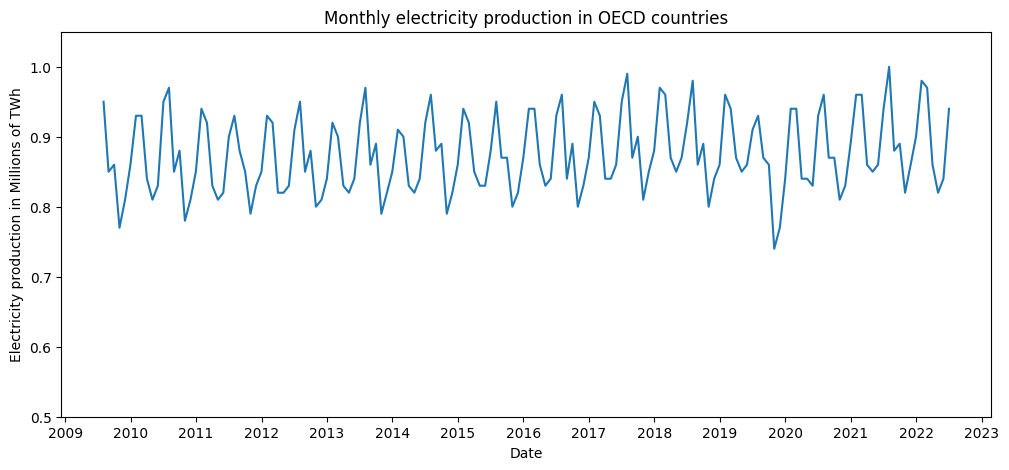

<Figure size 640x480 with 0 Axes>

In [267]:
# visualize monthly electricity production
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.lineplot(data=data_oecd_t_monthly, x='date', y='value_m')
ax.set_ylim(0.5, 1.05)
ax.set(title='Monthly electricity production in OECD countries',
        ylabel='Electricity production in Millions of TWh', xlabel='Date')
# set x_ticks and x_ticks labels
x_ticks = pd.date_range(start='2009-07-01', end='2023-07-01', freq=pd.DateOffset(years=1))
ax.set_xticks(x_ticks.to_pydatetime())
ax.set_xticklabels([x.strftime('%Y') for x in x_ticks])
plt.show()
plt.clf()

In [268]:
# create a pivot table with total monthly electricity production
data_oecd_t_monthly_pivot = data_oecd_t_monthly.pivot(columns='month', index='year', values='value_m')
data_oecd_t_monthly_pivot.columns = months_list
data_oecd_t_monthly_pivot.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2010,0.95,0.85,0.86,0.77,0.81,0.86,0.93,0.93,0.84,0.81,0.83,0.95
2011,0.97,0.85,0.88,0.78,0.81,0.85,0.94,0.92,0.83,0.81,0.82,0.90
2012,0.93,0.88,0.85,0.79,0.83,0.85,0.93,0.92,0.82,0.82,0.83,0.91
2013,0.95,0.85,0.88,0.80,0.81,0.84,0.92,0.90,0.83,0.82,0.84,0.92
2014,0.97,0.86,0.89,0.79,0.82,0.85,0.91,0.90,0.83,0.82,0.84,0.92


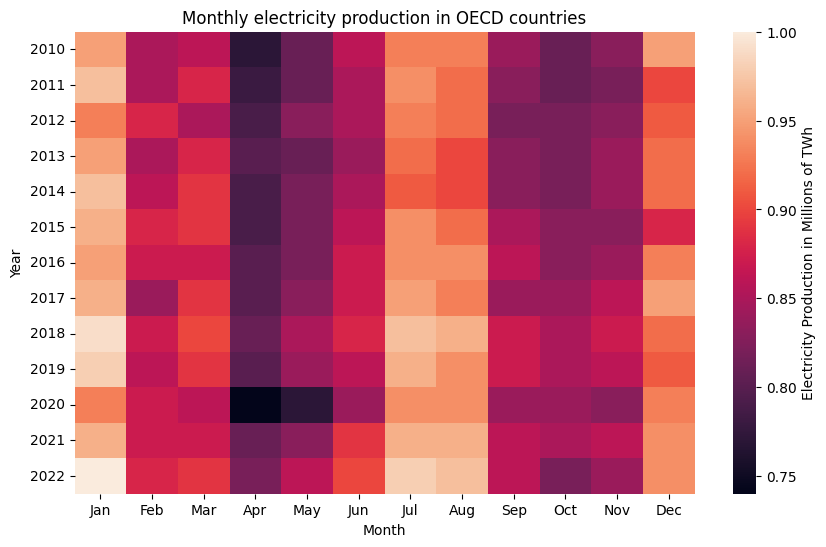

<Figure size 640x480 with 0 Axes>

In [269]:
# plot a heatmap of total electricity production
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(data_oecd_t_monthly_pivot, fmt=',.0f',
                 cbar_kws={'label': 'Electricity Production in Millions of TWh'})
ax.set(title='Monthly electricity production in OECD countries',
        ylabel='Year', xlabel='Month')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
plt.show()
plt.clf()

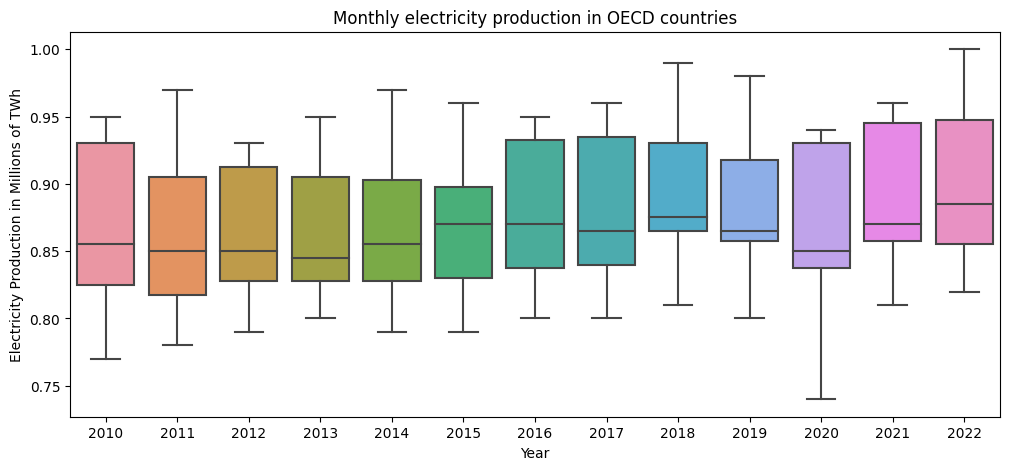

<Figure size 640x480 with 0 Axes>

In [270]:
# plot boxplots of electricity production for each year
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.boxplot(x=data_oecd_t_monthly['year'], y=data_oecd_t_monthly['value_m'])
ax.set(title='Monthly electricity production in OECD countries',
        ylabel='Electricity Production in Millions of TWh', xlabel='Year')
plt.show()
plt.clf()

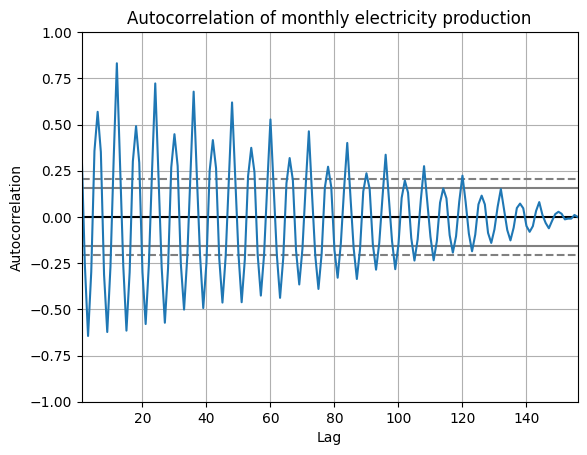

<Figure size 640x480 with 0 Axes>

In [271]:
# import autocorrelation_plot function
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(data_oecd_t_monthly['value_m'])
ax.set_title('Autocorrelation of monthly electricity production')
plt.show()
plt.clf()

<a id="eda_3"></a>

### 3. What are the proportions for different energy sources in the OECD total electricity production? How did they change over the period 2010-2022?

[(Back to Table of Contents)](#contents)

As can be seen on the visualization below, in 2010 **_Coal_** accounted for the largest proportion of total electricity produced by OECD countries: ~33.5%. The use of coal decreased over the years, especially after 2015. In 2022 only 19.3% of total electricity was produced using Coal, which represents a drop of -14.2%. In 2022 Coal was the 2nd most-used energy source.

**_Natural gas_** was 2nd most-used energy source in 2010 - it accounted for 23.4%. The use of Natural gas actually increased over the years. In 2022 Natural gas was the most-used energy source with the share of 29.8% - an increase of 6.4% from 2010 level.

Third most-used energy source in 2010 was **_Nuclear_** with the share of 21% of total electricity produced. There was significant decline in 2011 and 2012 down to 18%, followed by fairly stable period up until 2022 when Nuclear proportion dropped down to 15.8% - a decrease of -5.2% over 2010-2022 period. It was the 3rd most-used energy source in 2022.

**_Hydro_** was the 4th most-used energy source in 2010 which accounted for 13.6% of total electricity produced. The use of Hydro remained fairly stable over the years, and only 2020 stands out when Hydro share increased to 15%. In 2022 Hydro rate came down to 13.6%, the same level it was back in 2010, and it remained the 4th most used energy source.

Fifth most-used energy source in 2010 was **_Oil_**: 2.8% of total electricity production. The use of Oil increased in 2011-2012 up to 3.7% and was 
decreasing after that up until 2019. Since 2019 the use of Oil is fairly stable, in 2022 it accounted for 1.7% of all electricity produced - a decrease of -1.1% over 2010-2022 period. Oil was 8th most-used energy source in 2022.

**_Wind_** was the 6th most-used energy source in 2010, it accounted for 2.6% of all electricity production. The use of Wind increased significantly every year after 2010. In 2022 its share increased to 10.1% (a jump of 7.5% or more than 2.5 times if compared with 2010 rate). Wind became he 5th most-used energy source in 2022.

**_Combustible renewables_** (solid and liquid biofuels, biogases, municipal renewable waste) was the 7-th most-used energy source in 2010 with the share of 2%. The use of Combustible renewables increased slowly in 2010-2021 with a small drop in 2022. It remained the 7th most-used energy source in 2022 with a 3% share (increase of 1% from 2010).

**_Other combustible non-renewables_** (industrial and non-renewable municipal solid waste) was the 8th largest energy source in 2010 with a proportion of ~0.4%. Its use remained fairly stable in 2010-2022; in 2022 it was the least-used energy source with 0.5% share. 

**_Geothermal_** was 9th largest energy source in 2010 with the share of ~0.4%. Its use increased slowly in 2010-2022 period; in 2022 it remained the 9th largest energy source with ~0.5% proportion.

The least used energy source in 2010 was **_Solar_** with a proportion of only ~0.3%. Solar use increased significantly in 2010-2022 period with especially noticeable jumps in 2021 and 2022. It became the 5th largest energy source in 2022 with 5.7% share (a jump of 5.4% or 18 times if compared with 2010 level - a true success story for the renewable energy).

In [272]:
# calculate total yearly productions for each energy source
data_oecd_total_sources = data_regions[data_regions['country'] == 'OECD Total'].groupby(['year', 'product'])['value'].sum().reset_index()
data_oecd_total_sources.head()

,year,product,value
0,2010,Coal,3484643.071
1,2010,Combustible renewables,206740.780
2,2010,Geothermal,39547.812
3,2010,Hydro,1418078.118
4,2010,Natural gas,2435725.201


In [273]:
# calculate rates from total yearly production for each energy source
data_oecd_total_sources = data_oecd_total_sources.merge(right=data_regions_grand_total.\
                          drop(['region', 'perc_change_prev_year', 'perc_change_from_2010'], axis=1), how='left', on='year')
data_oecd_total_sources.columns = ['year', 'energy_source', 'source_total', 'oecd_total']
data_oecd_total_sources['percent_oecd_total'] = (data_oecd_total_sources['source_total'] /
                                                 data_oecd_total_sources['oecd_total'] * 100).round(3)
data_oecd_total_sources.head()

,year,energy_source,source_total,oecd_total,percent_oecd_total
0,2010,Coal,3484643.071,1.039544e+07,33.521
1,2010,Combustible renewables,206740.780,1.039544e+07,1.989
2,2010,Geothermal,39547.812,1.039544e+07,0.380
3,2010,Hydro,1418078.118,1.039544e+07,13.641
4,2010,Natural gas,2435725.201,1.039544e+07,23.431


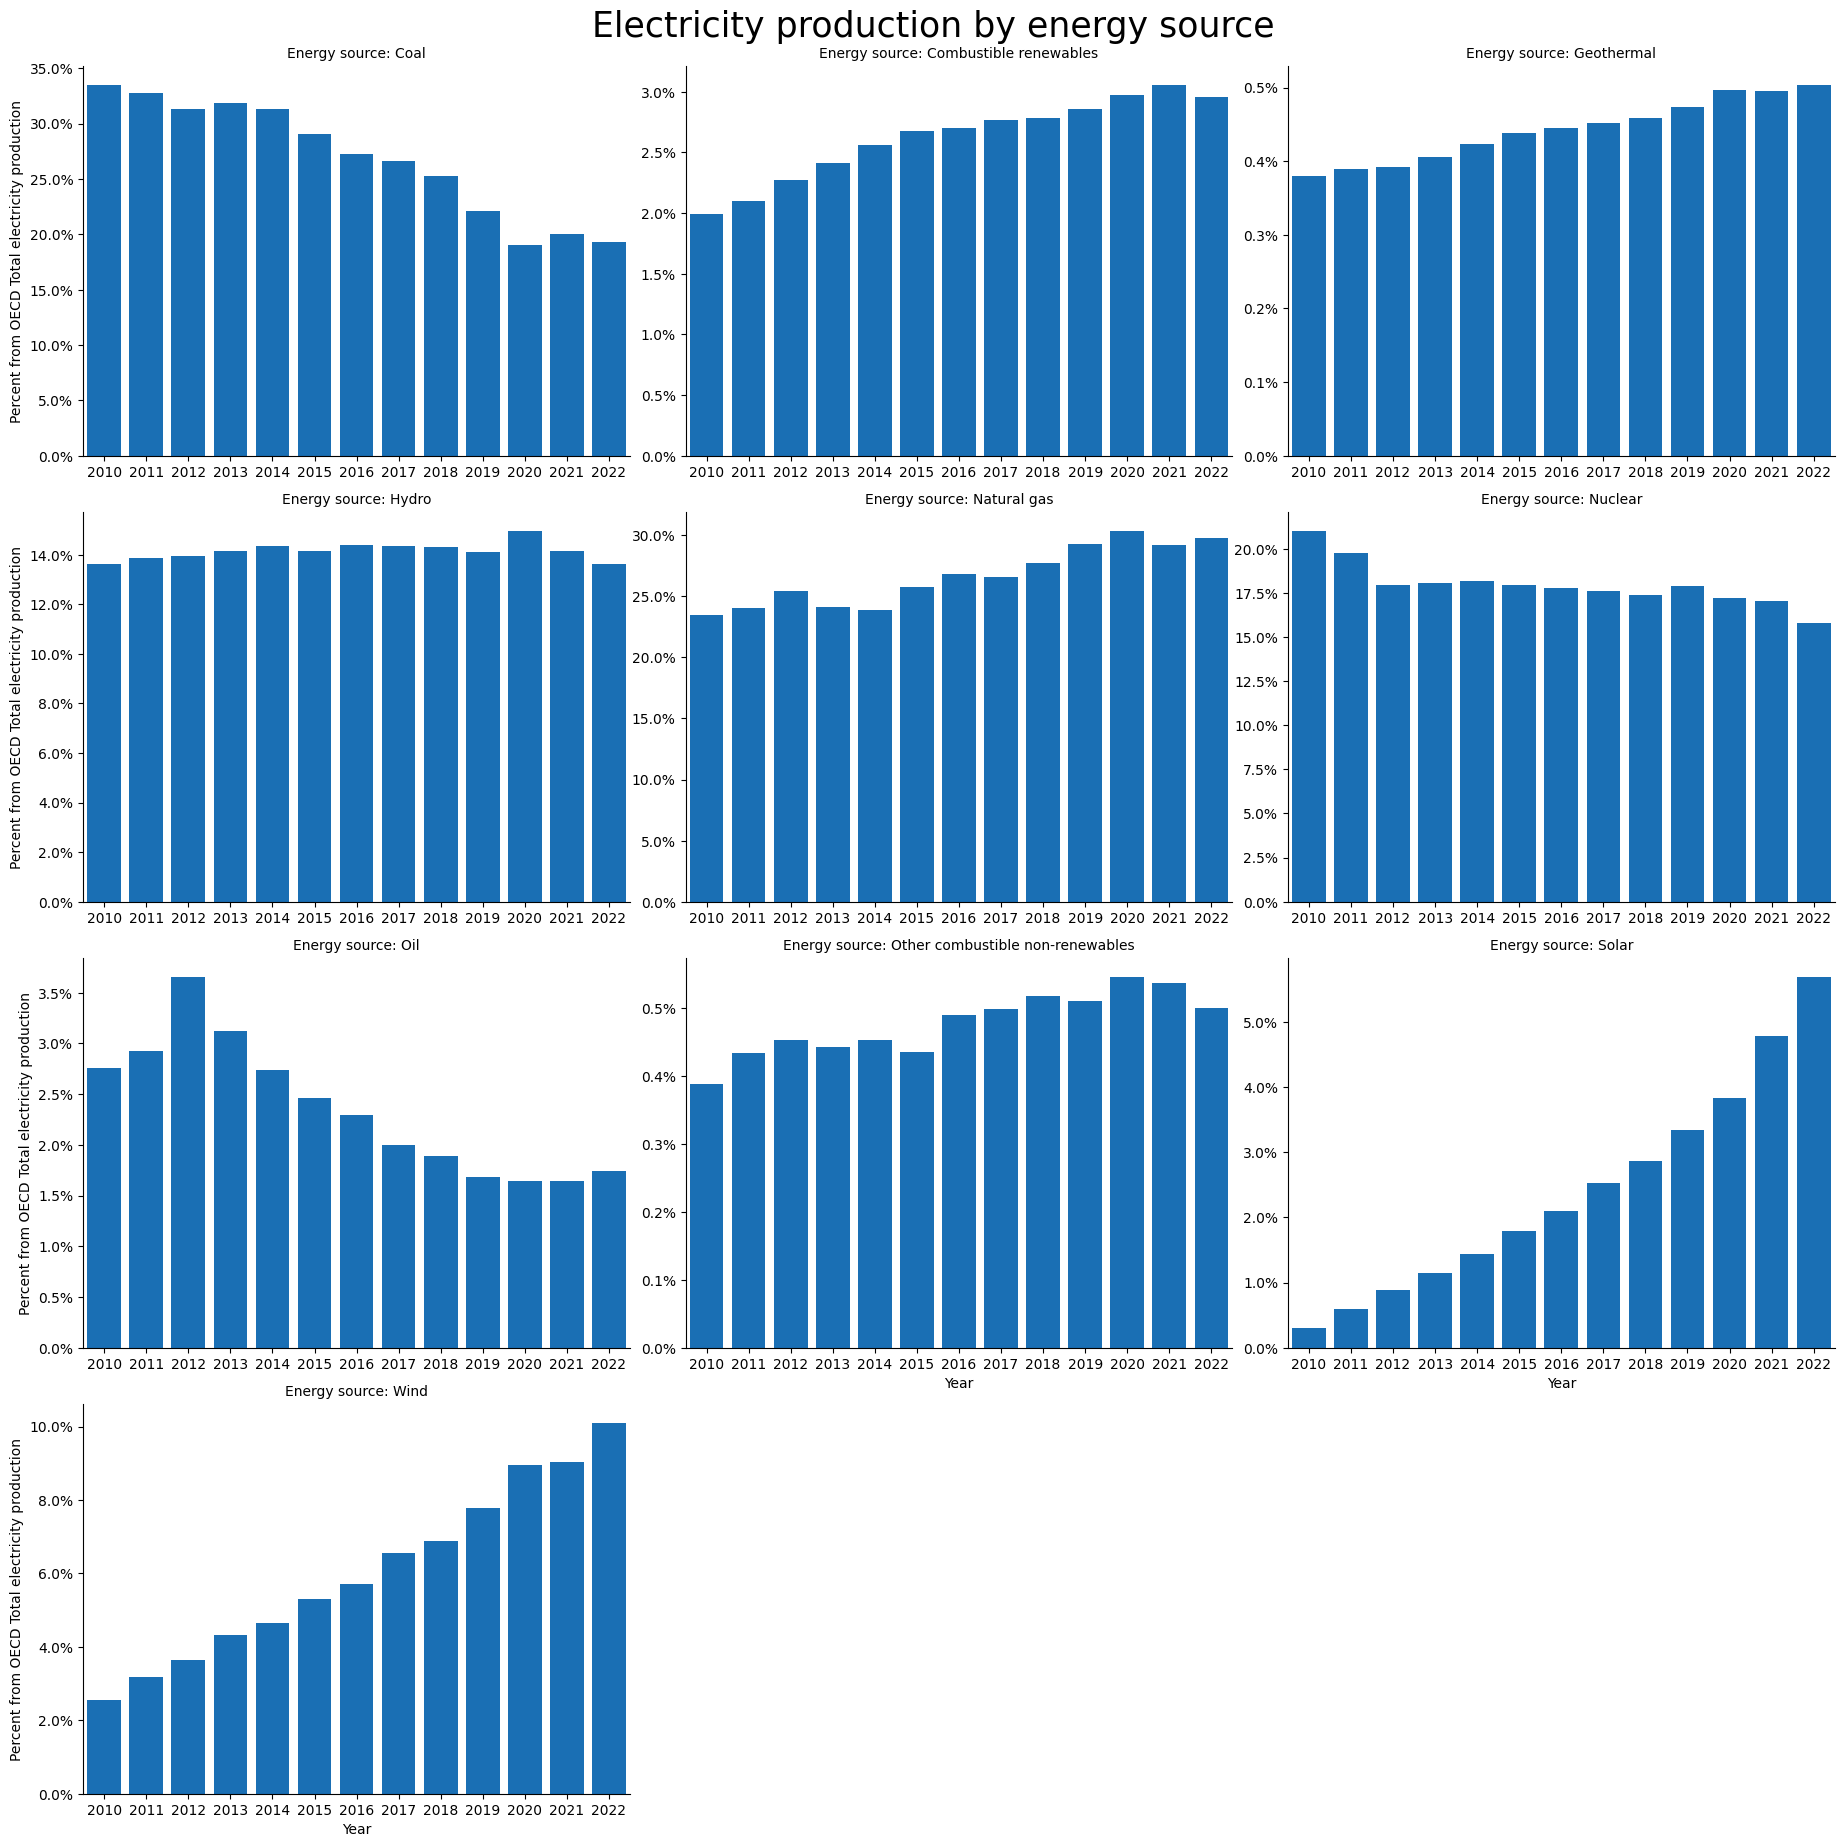

<Figure size 640x480 with 0 Axes>

In [274]:
# visualize electricity production for each energy source
g = sns.catplot(data=data_oecd_total_sources, x='year', y='percent_oecd_total', col='energy_source', col_wrap=3, kind='bar',
                sharex=False, sharey=False, height=4.7, aspect=1.3, color='#0072CE')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=1))
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Electricity production by energy source', fontsize=25)
g.set_titles("Energy source: {col_name}")
g.set_axis_labels(x_var='Year', y_var='Percent from OECD Total electricity production')
plt.show()
plt.clf()

### 4. What were the top-5 energy sources in each OECD region in 2022? <a id="eda_4"></a>

[(Back to Table of Contents)](#contents)

As can be seen from the graph below, if we consider electricity production for **_OECD Total_** in 2022, top-5 energy sources were: *Natural Gas*, *Coal*, *Nuclear*, *Hydro* and *Wind* (in order from largest production to smallest). There was a big difference in the amount of electricity produced between *Natural gas* (1st place) and *Coal* (2nd place), differences between other places were not so significant.

The **_OECD Americas_** region's top-5 energy sources were the same and in the same order as for the OECD Total, however a gap between *Natural gas* (1st place) and *Coal* (2nd place) was even bigger. Also difference between *Hydro* (4th place) and *Wind* (5th place) was substantial.

For the **_OECD Europe_** region top-5 energy sources were: *Natural gas*, *Nuclear*, *Wind*, *Hydro* and *Coal*. Amount of electricity produced using *Wind*, *Hydro* and *Coal* was pretty much on the same level.

The **_OECD Asia Oceania_** region's top-5 energy sources were: *Coal*, *Natural Gas*, *Nuclear*, *Solar* and *Hydro*. There was a very big difference in electricity production between *Natural gas* (2nd place) and *Nuclear* (3rd place). It's interesting to note that only this region doesn't have *Wind* in top-5 sources but has *Solar*.

In [275]:
# calculate totals for each energy source for OECD regions
regions_total_sources = data_regions.groupby(['country', 'year', 'product'])['value'].sum().reset_index()
regions_total_sources.columns = ['region', 'year', 'energy_source', 'total']
# separate totals for 2022 in a new df
regions_total_sources_2022 = regions_total_sources[regions_total_sources['year'] == 2022].reset_index(drop=True)
regions_total_sources_2022.head()

,region,year,energy_source,total
0,OECD Americas,2022,Coal,9.463118e+05
1,OECD Americas,2022,Combustible renewables,6.863287e+04
2,OECD Americas,2022,Geothermal,2.312978e+04
3,OECD Americas,2022,Hydro,8.025672e+05
4,OECD Americas,2022,Natural gas,1.944270e+06


In [276]:
# keep only top-5 energy sources for each region
regions_total_sources_2022 = regions_total_sources_2022.groupby('region').apply(lambda x: x.nlargest(5, ['total'])).\
                             reset_index(drop=True)
regions_total_sources_2022['total_thousands_twh'] = round(regions_total_sources_2022['total']/1000, 0)
regions_total_sources_2022.head(7)

,region,year,energy_source,total,total_thousands_twh
0,OECD Americas,2022,Natural gas,1.944270e+06,1944.0
1,OECD Americas,2022,Coal,9.463118e+05,946.0
2,OECD Americas,2022,Nuclear,8.638061e+05,864.0
3,OECD Americas,2022,Hydro,8.025672e+05,803.0
4,OECD Americas,2022,Wind,5.059649e+05,506.0
5,OECD Asia Oceania,2022,Coal,6.048043e+05,605.0
6,OECD Asia Oceania,2022,Natural gas,5.567354e+05,557.0


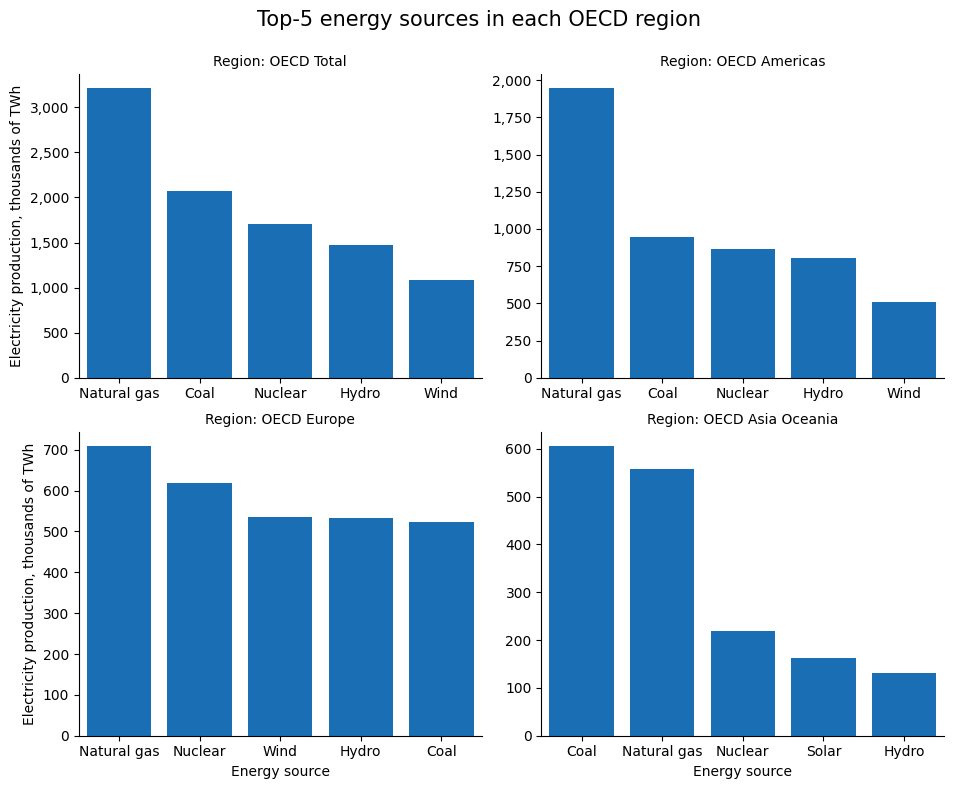

<Figure size 640x480 with 0 Axes>

In [277]:
# plot top-5 energy sources for each region
g = sns.catplot(data=regions_total_sources_2022, x='energy_source', y='total_thousands_twh', col='region',
                col_order=['OECD Total', 'OECD Americas', 'OECD Europe', 'OECD Asia Oceania'], col_wrap=2, kind='bar',
                sharex=False, sharey=False, height=4, aspect=1.2, color='#0072CE')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Top-5 energy sources in each OECD region', fontsize=15)
g.set_titles("Region: {col_name}")
g.set_axis_labels(x_var='Energy source', y_var='Electricity production, thousands of TWh')
plt.show()
plt.clf()

### 5. How did the total low-carbon electricity production in OECD countries change in 2010-2022 period? <a id="eda_5"></a>

[(Back to Table of Contents)](#contents)

**_Low-carbon energy sources_** include:
* Combustible renewables
* Geothermal
* Hydro
* Nuclear
* Solar
* Wind

To investigate how total low-carbon electricity production changed over the years, for each year I will look into the changes (%) from previous year's low-carbon production (first graph) and from the baseline production in 2010 (~ 4.1M TWh, second graph).

The first graph shows that if looking into **_changes from previous year's production_**, there were 2 years when low-carbon production decreased (2011, 2012) with the largest drop in 2011 (-2% drop from previous year). In the remaining years the low-carbon electricity production increased, with the highest rises in 2013 and 2021 (3.5% growth in both years).

The second chart shows that if we look into **_changes from baseline 2010 production_**, there were 2 years when total production was below the baseline (2011 and 2012) with the largest drop in 2012 (-2.3% from baseline production). In the remaining years the electricity production increased significantly above the baseline production, with the highest rises in 2021 and 2022 (24.9% and 26.4% respectively).

In [278]:
# Define low-carbon energy sources
low_carbon_generation_sources = ['Combustible renewables', 'Geothermal', 'Hydro', 'Nuclear', 'Solar', 'Wind']

In [279]:
# Calculate totals for low carbon production
data_regions_low_carbon = regions_total_sources[regions_total_sources['energy_source'].isin(low_carbon_generation_sources)]
data_regions_low_carbon = data_regions_low_carbon.groupby(['region', 'year'])['total'].sum().reset_index()
data_regions_low_carbon.rename({'total': 'low_carbon_total'}, axis=1, inplace=True)
data_regions_low_carbon.head()

,region,year,low_carbon_total
0,OECD Americas,2010,1790029.203
1,OECD Americas,2011,1893108.743
2,OECD Americas,2012,1854636.253
3,OECD Americas,2013,1929163.838
4,OECD Americas,2014,2022111.249


In [280]:
# separate data for OECD Total
oecd_total_low_carbon = data_regions_low_carbon[data_regions_low_carbon['region'] == 'OECD Total'].reset_index(drop=True)
# calculate percent of change in total production from previous year production
oecd_total_low_carbon['perc_change_prev_year'] = round(oecd_total_low_carbon['low_carbon_total'].diff()/oecd_total_low_carbon['low_carbon_total'].\
                                                 shift(1)*100, 1)
# set value to percent of change for 2010
oecd_total_low_carbon['perc_change_prev_year'].fillna(0, inplace=True)
oecd_total_low_carbon.head()

,region,year,low_carbon_total,perc_change_prev_year
0,OECD Total,2010,4147929.921,0.0
1,OECD Total,2011,4134951.271,-0.3
2,OECD Total,2012,4053584.833,-2.0
3,OECD Total,2013,4195171.759,3.5
4,OECD Total,2014,4325578.024,3.1


In [281]:
# set amount of low-carbon electricity produced in 2010 as a baseline
baseline_oecd_low_carbon = oecd_total_low_carbon[oecd_total_low_carbon['year'] == 2010]['low_carbon_total'].item()
# calculate percent of change from baseline for each year
oecd_total_low_carbon['perc_change_from_2010'] = round((oecd_total_low_carbon['low_carbon_total'] - baseline_oecd_low_carbon)/\
                                                        baseline_oecd_low_carbon*100, 1)
oecd_total_low_carbon

,region,year,low_carbon_total,perc_change_prev_year,perc_change_from_2010
0,OECD Total,2010,4.147930e+06,0.0,0.0
1,OECD Total,2011,4.134951e+06,-0.3,-0.3
2,OECD Total,2012,4.053585e+06,-2.0,-2.3
3,OECD Total,2013,4.195172e+06,3.5,1.1
4,OECD Total,2014,4.325578e+06,3.1,4.3
5,OECD Total,2015,4.418674e+06,2.2,6.5
6,OECD Total,2016,4.539786e+06,2.7,9.4
7,OECD Total,2017,4.672904e+06,2.9,12.7
8,OECD Total,2018,4.808025e+06,2.9,15.9
9,OECD Total,2019,4.928948e+06,2.5,18.8


In [282]:
# separate positive and negative changes into separate subsets for color differentiation in viz
# for previous year changes
oecd_total_low_carbon_py_pos = oecd_total_low_carbon[oecd_total_low_carbon['perc_change_prev_year'] >= 0]
oecd_total_low_carbon_py_neg = oecd_total_low_carbon[oecd_total_low_carbon['perc_change_prev_year'] < 0]
# for baseline changes
oecd_total_low_carbon_bl_pos = oecd_total_low_carbon[oecd_total_low_carbon['perc_change_from_2010'] >= 0]
oecd_total_low_carbon_bl_neg = oecd_total_low_carbon[oecd_total_low_carbon['perc_change_from_2010'] < 0]

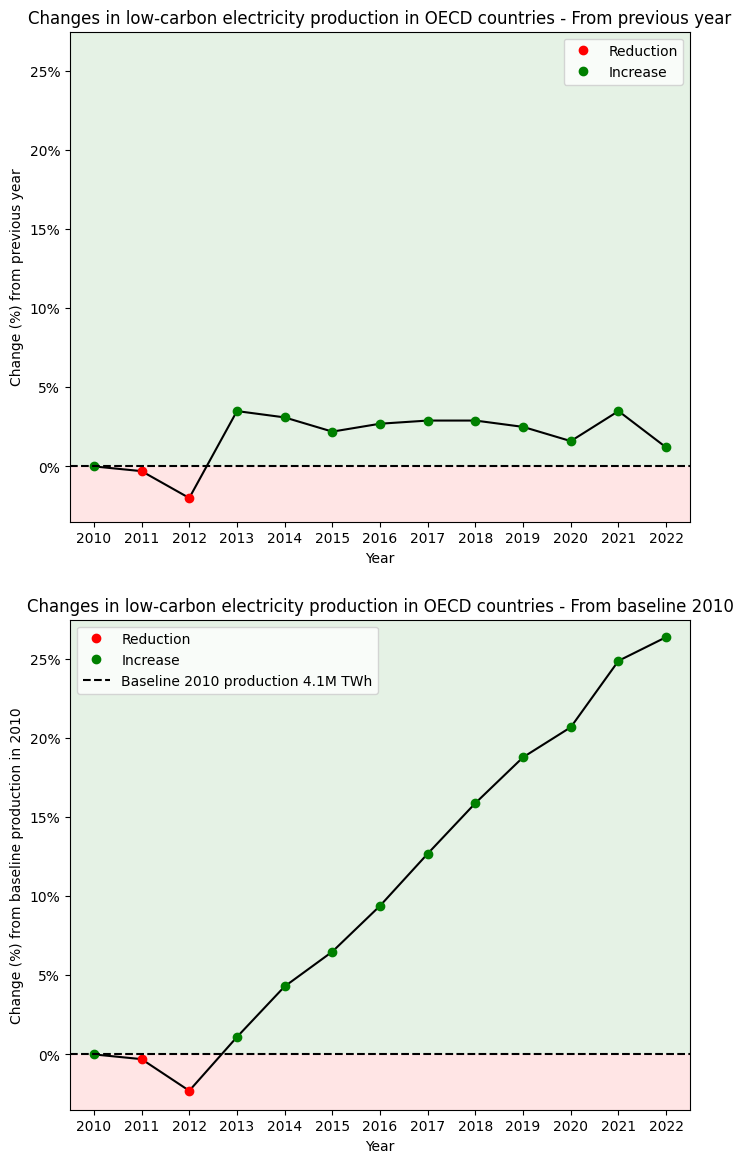

<Figure size 640x480 with 0 Axes>

In [283]:
# plot changes in low-carbon electricity production
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 14), sharey=True)

# plot line chart of changes from previous year
ax1.plot(oecd_total_low_carbon['year'], oecd_total_low_carbon['perc_change_prev_year'], color='black')
ax1.plot(oecd_total_low_carbon_py_neg['year'], oecd_total_low_carbon_py_neg['perc_change_prev_year'],
        color='red', marker='o', linestyle='None', label='Reduction')
ax1.plot(oecd_total_low_carbon_py_pos['year'], oecd_total_low_carbon_py_pos['perc_change_prev_year'],
        color='green', marker='o', linestyle='None', label='Increase')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_ylim(-3.5, 27.5)
ax1.set_xlim(2009.5, 2022.5)
ax1.fill_between((2009.5, 2022.5), 0, 27.5, facecolor='green', alpha=0.1)
ax1.fill_between((2009.5, 2022.5), -3.5, 0, facecolor='red', alpha=0.1)
ax1.set_xticks(ticks=range(2010, 2023))
ax1.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=0))
ax1.legend()
ax1.set(title='Changes in low-carbon electricity production in OECD countries - From previous year',
        xlabel='Year', ylabel='Change (%) from previous year')

# plot line chart of changes from baseline 2010
ax2.plot(oecd_total_low_carbon['year'], oecd_total_low_carbon['perc_change_from_2010'], color='black')
ax2.plot(oecd_total_low_carbon_bl_neg['year'], oecd_total_low_carbon_bl_neg['perc_change_from_2010'],
         color='red', marker='o', linestyle='None', label='Reduction')
ax2.plot(oecd_total_low_carbon_bl_pos['year'], oecd_total_low_carbon_bl_pos['perc_change_from_2010'],
         color='green', marker='o', linestyle='None', label='Increase')
ax2.axhline(0, color='black', label='Baseline 2010 production 4.1M TWh', linestyle='--')
ax2.set_xlim(2009.5, 2022.5)
ax2.fill_between((2009.5, 2022.5), 0, 27.5, facecolor='green', alpha=0.1)
ax2.fill_between((2009.5, 2022.5), -3.5, 0, facecolor='red', alpha=0.1)
ax2.set_xticks(ticks=range(2010, 2023))
ax2.legend()
ax2.set(title='Changes in low-carbon electricity production in OECD countries - From baseline 2010',
        xlabel='Year', ylabel='Change (%) from baseline production in 2010')
plt.show()
plt.clf()

<a id="eda_6"></a>

### 6. What is the percentage of low-carbon power generation in OECD regions? How did it change over 2010-2022 period? Did all regions have the same pattern?

[(Back to Table of Contents)](#contents)

As can be seen from the graph below, for **_all OECD countries_** (marked as 'OECD Total') the proportion of low-carbon electricity rose steadily in 2010-2022 except for 2012 where we can see a slight drop. In 2010 low-carbon electricity share was 40% and it increased to 48.7% in 2022 (8.7% growth over this period).

The **_OECD Americas region_** shared very similar pattern for low-carbon electricity production when compared to all OECD countries: slight drop in 2012 and 2018 and steady growth in all other years. The share of low-carbon electricity for this region was slightly below the share for all OECD countries, it was 35.4% in 2010 and it increased to 45.3% in 2022 (9.9% growth over this period).

The **_OECD Europe_** region had a much higher proportion of low-carbon electricity production when compared to all other regions. The proportion of low-carbon electricity rose significantly up to 2020 and it came down a bit in 2021 and 2022. In 2010 low-carbon electricity share was 50.4%, it increased to 62.3% in 2022 (11.9% growth over this period).

The **_OECD Asia Oceania_** region had the lowest proportion of low-carbon electricity. Even though it started in 2010 at a similar level as OECD Americas region, OECD Asia Oceania experienced a significant drop in 2011 and 2012. The share of low-carbon electricity production rose significantly after 2014 and recovered to 2010 level in 2021. In 2010 low-carbon electricity share was 32.5%, it increased to 33.5% in 2022 (1% growth over this period). This huge drop in low-carbon electricity share in this region in 2011 and 2012 is worth investigating separately.

In [284]:
# calculate total production for each region and add this to data_regions_low_carbon
data_regions_totals2 = data_regions.groupby(['country', 'year'])['value'].sum().reset_index()
data_regions_totals2.columns = ['region', 'year', 'region_total']
data_regions_low_carbon = data_regions_low_carbon.merge(data_regions_totals2, how='left', on=['region', 'year'])
# calculate percentage of low carbon production from total production
data_regions_low_carbon['perc_low_carbon'] = round(data_regions_low_carbon['low_carbon_total']/data_regions_low_carbon['region_total']*100,1)
data_regions_low_carbon.head()

,region,year,low_carbon_total,region_total,perc_low_carbon
0,OECD Americas,2010,1790029.203,5060520.726,35.4
1,OECD Americas,2011,1893108.743,5087526.905,37.2
2,OECD Americas,2012,1854636.253,5035590.799,36.8
3,OECD Americas,2013,1929163.838,5083181.394,38.0
4,OECD Americas,2014,2022111.249,5186828.032,39.0


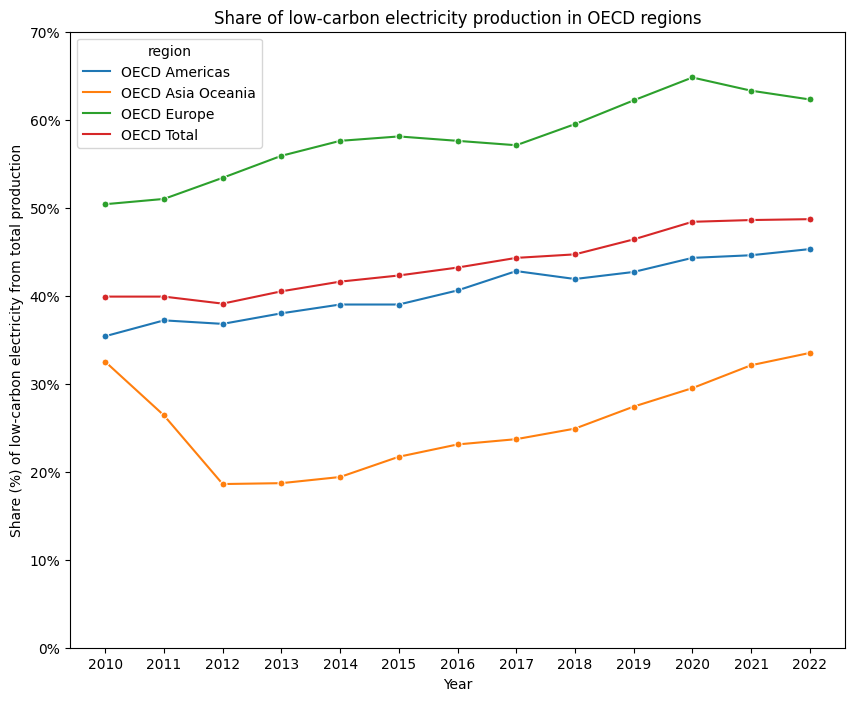

<Figure size 640x480 with 0 Axes>

In [285]:
# plot share of low-carbon electricity production in each region
fig1, ax1 = plt.subplots(figsize=(10, 8))
sns.lineplot(data=data_regions_low_carbon, x='year', y='perc_low_carbon', hue='region', marker='o', markersize=5, ax=ax1)
ax1.set_ylim(0, 70)
ax1.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=0))
ax1.set_xticks(ticks=range(2010, 2023))
ax1.set(title='Share of low-carbon electricity production in OECD regions', xlabel='Year',
        ylabel='Share (%) of low-carbon electricity from total production')
plt.show()
plt.clf()

#### As was discovered in Q.6, OECD Asia Oceania region experienced a very significant drop in the proportion of low-carbon electricity production in 2011 and 2012. How did total electricity production changed in that period in this region? What were the changes if we look into electricity production by different energy sources? 

As can be seen on the first graph, there were no significant changes in the *OECD Asia Oceania region* in **_total electricity production_**. However, there was a very significant decrease in **_low-carbon electricity production_** in 2011-2012 years: it came down from 0.6M TWh in 2010 to 0.48M TWh in 2011 and then down to 0.34M TWh in 2012. After 2012 the production of low-carbon electricity started to grow steadily, but only in 2022 it fully recovered to 2010 level.

The second graph shows us **_electricity production in this region by different energy sources_**. We can see a very significant drop in *Nuclear* production in 2011 and 2012 which was compensated by increases in *Natural gas* and *Oil* production. On 11 March 2011 a nuclear accident occurred at the Fukushima Daiichi Nuclear Power Plant in Japan caused by the earthquake and tsunami. By March 2012 all but two of Japan's nuclear reactors had been shut down which resulted in nearly a 30% loss of the country's generating capacity. And the graph clearly shows that the whole region was impacted.

In [286]:
# save data for OECD Asia Oceania into a separate df
asia_low_carbon = data_regions_low_carbon[data_regions_low_carbon['region'] == 'OECD Asia Oceania'].drop('perc_low_carbon', axis=1)
asia_low_carbon.head()

,region,year,low_carbon_total,region_total
13,OECD Asia Oceania,2010,602093.548,1852461.572
14,OECD Asia Oceania,2011,486159.367,1838729.745
15,OECD Asia Oceania,2012,343144.381,1849493.831
16,OECD Asia Oceania,2013,341788.467,1828907.596
17,OECD Asia Oceania,2014,356573.877,1836358.351


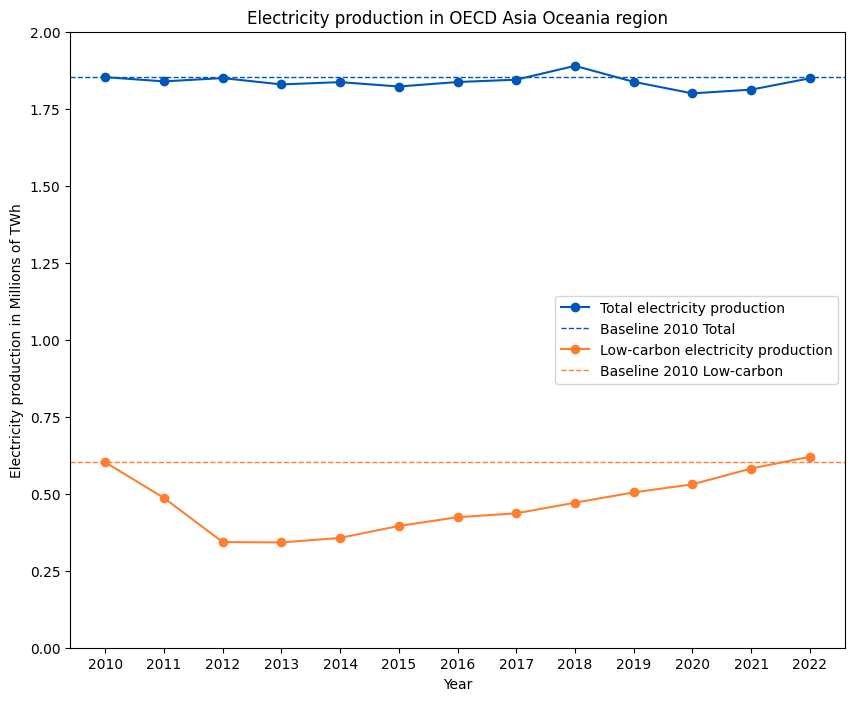

<Figure size 640x480 with 0 Axes>

In [287]:
# visualize total and low-carbon production in OECD Asia Oceania
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(asia_low_carbon['year'], asia_low_carbon['region_total']/1000000, marker='o', label='Total electricity production', color='#0057B8')
ax1.axhline(asia_low_carbon[asia_low_carbon['year'] == 2010]['region_total'].item()/1000000, linestyle='--', color='#0057B8', lw=1,
            label='Baseline 2010 Total')
ax1.plot(asia_low_carbon['year'], asia_low_carbon['low_carbon_total']/1000000, marker='o', label='Low-carbon electricity production', color='#FF7F32')
ax1.axhline(asia_low_carbon[asia_low_carbon['year'] == 2010]['low_carbon_total'].item()/1000000, linestyle='--', color='#FF7F32', lw=1,
            label='Baseline 2010 Low-carbon')
ax1.set_ylim(0, 2)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xticks(ticks=range(2010, 2023))
ax1.set(title='Electricity production in OECD Asia Oceania region', xlabel='Year',
        ylabel='Electricity production in Millions of TWh')
ax1.legend(loc=7)
plt.show()
plt.clf()

In [288]:
# calculate total yearly productions for each energy source for OECD Asia Oceania
asia_total_sources = data_regions[data_regions['country'] == 'OECD Asia Oceania'].groupby(['year', 'product'])['value'].sum().\
                     reset_index()
asia_total_sources.columns = ['year', 'energy_source', 'total']
asia_total_sources = asia_total_sources.sort_values(by=['year', 'total'], ascending=[True, False]).reset_index(drop=True)
asia_total_sources['total_thousands'] = round(asia_total_sources['total'] / 1000, 0)
asia_total_sources.head()

,year,energy_source,total,total_thousands
0,2010,Coal,670920.689,671.0
1,2010,Natural gas,461397.073,461.0
2,2010,Nuclear,420258.596,420.0
3,2010,Hydro,142007.098,142.0
4,2010,Oil,107233.814,107.0


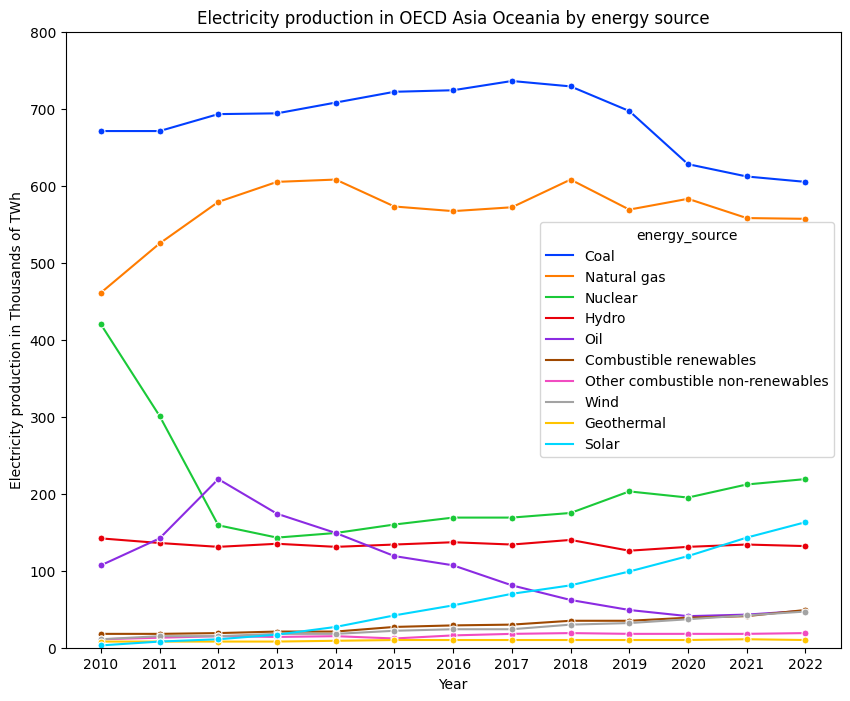

<Figure size 640x480 with 0 Axes>

In [289]:
# plot electricity production by energy source for OECD Asia Oceania
fig1, ax1 = plt.subplots(figsize=(10, 8))
sns.lineplot(data=asia_total_sources, x='year', y='total_thousands', hue='energy_source', marker='o', markersize=5, ax=ax1,
             palette='bright')
ax1.set_ylim(0, 800)
ax1.set_xticks(ticks=range(2010, 2023))
ax1.set(title='Electricity production in OECD Asia Oceania by energy source', xlabel='Year',
        ylabel='Electricity production in Thousands of TWh')
plt.show()
plt.clf()

<a id="eda_7"></a>

### 7. What are the top-10 countries that produced the largest amount of electricity in 2022? In which OECD regions are they located?

[(Back to Table of Contents)](#contents)

First graph hows a *histogram of electricity production*. We can see that the distribution is right-skewed with the majority of values for electricity production concentrated below 0.4M GWh.

Second chart shows *top-10 countries from our dataset with largest electricity production in 2022*. **_The United States_** is by far the largest electricity producer (4.3M of GWh), **_India_** is on 2nd place (1.6M of GWh) and **_Japan_** is on the 3rd place (0.98M of GWh).

In the top-10 set there are 3 countries from the **_OECD Americas_** region (the United States, Canada and Mexico), 2 countries from the **_OECD Asia Oceania_** region (Japan, Korea), 3 countries from the **_OECD Europe_** region (Germany, France, United Kingdom) and 2 **_non-OECD economies_** (India and Brazil).

In [290]:
# calculate total production for each country in 2022 and sort by production from largest to smallest
countries_total_2022 = data_countries[data_countries['year'] == 2022].groupby('country')['value'].sum().\
                       sort_values(ascending=False).round(0).reset_index()
countries_total_2022.columns = ['country', 'prod_tot']
# create column with production in Millions of GWh
countries_total_2022['prod_tot_mil_gwh'] = round(countries_total_2022['prod_tot']/1000000, 3)
countries_total_2022.head()

,country,prod_tot,prod_tot_mil_gwh
0,United States,4328012.0,4.328
1,India,1649272.0,1.649
2,Japan,983016.0,0.983
3,Brazil,639585.0,0.640
4,Canada,638138.0,0.638


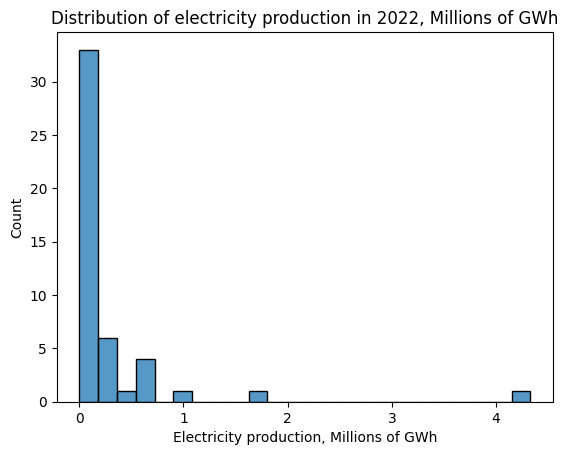

<Figure size 640x480 with 0 Axes>

In [291]:
# visualize distribution of electricity production in 2022
ax1 = sns.histplot(data=countries_total_2022, x='prod_tot_mil_gwh', bins=24)
ax1.set(title='Distribution of electricity production in 2022, Millions of GWh', xlabel='Electricity production, Millions of GWh')
plt.show()
plt.clf()

In [292]:
# save top-10 countries to a new df
countries_total_2022_top_10 = countries_total_2022.nlargest(10, 'prod_tot')
countries_total_2022_top_10

,country,prod_tot,prod_tot_mil_gwh
0,United States,4328012.0,4.328
1,India,1649272.0,1.649
2,Japan,983016.0,0.983
3,Brazil,639585.0,0.640
4,Canada,638138.0,0.638
5,Korea,560825.0,0.561
6,Germany,551479.0,0.551
7,France,451167.0,0.451
8,Mexico,334507.0,0.335
9,United Kingdom,317632.0,0.318


In [293]:
# define regions and countries
oecd_regional_groupings = {
    'OECD Americas': ['Canada', 'Chile', 'Colombia', 'Costa Rica', 'Mexico', 'United States'],
    'OECD Asia Oceania': ['Australia', 'Japan', 'Korea', 'New Zealand'],
    'OECD Europe': ['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
                    'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden','Switzerland', 'Republic of Turkiye', 'United Kingdom']
}

# define a function to return region based on country
def get_region(country):
    for region, list_countries in oecd_regional_groupings.items():
        if country in list_countries:
            return region
        
# add region details to top-10 df
countries_total_2022_top_10['region'] = countries_total_2022_top_10['country'].apply(get_region)
countries_total_2022_top_10['region'].fillna('Non-OECD Economy', inplace=True)
countries_total_2022_top_10

,country,prod_tot,prod_tot_mil_gwh,region
0,United States,4328012.0,4.328,OECD Americas
1,India,1649272.0,1.649,Non-OECD Economy
2,Japan,983016.0,0.983,OECD Asia Oceania
3,Brazil,639585.0,0.640,Non-OECD Economy
4,Canada,638138.0,0.638,OECD Americas
5,Korea,560825.0,0.561,OECD Asia Oceania
6,Germany,551479.0,0.551,OECD Europe
7,France,451167.0,0.451,OECD Europe
8,Mexico,334507.0,0.335,OECD Americas
9,United Kingdom,317632.0,0.318,OECD Europe


In [294]:
# define colors for regions
oecd_regions_colors = {
    'OECD Americas': '#EE2737',
    'OECD Asia Oceania': '#FF7F32',
    'OECD Europe': '#00B140',
    'Non-OECD Economy': '#0057B8'
}

# define a function to return color based on region
def get_color(region):
    for reg, color in oecd_regions_colors.items():
        if reg == region:
            return color
        

# add colors to top-10 df
countries_total_2022_top_10['color'] = countries_total_2022_top_10['region'].apply(get_color)
countries_total_2022_top_10

,country,prod_tot,prod_tot_mil_gwh,region,color
0,United States,4328012.0,4.328,OECD Americas,#EE2737
1,India,1649272.0,1.649,Non-OECD Economy,#0057B8
2,Japan,983016.0,0.983,OECD Asia Oceania,#FF7F32
3,Brazil,639585.0,0.640,Non-OECD Economy,#0057B8
4,Canada,638138.0,0.638,OECD Americas,#EE2737
5,Korea,560825.0,0.561,OECD Asia Oceania,#FF7F32
6,Germany,551479.0,0.551,OECD Europe,#00B140
7,France,451167.0,0.451,OECD Europe,#00B140
8,Mexico,334507.0,0.335,OECD Americas,#EE2737
9,United Kingdom,317632.0,0.318,OECD Europe,#00B140


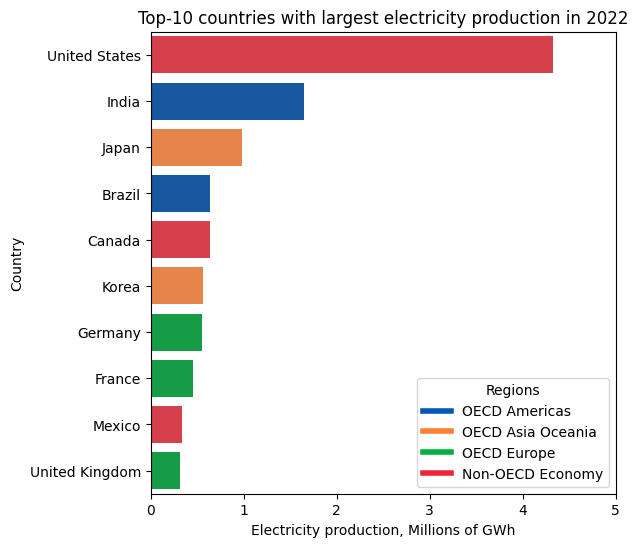

<Figure size 640x480 with 0 Axes>

In [295]:
# plot bar chart for top-10 countries
fig1, ax1 = plt.subplots(figsize=(6, 6))
sns.barplot(data=countries_total_2022_top_10, y='country', x='prod_tot_mil_gwh', ax=ax1, orient='h',
            palette=countries_total_2022_top_10['color'])
# create custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#0057B8', lw=4),
                Line2D([0], [0], color='#FF7F32', lw=4),
                Line2D([0], [0], color='#00B140', lw=4),
                Line2D([0], [0], color='#EE2737', lw=4)]
ax1.legend(custom_lines, oecd_regions_colors.keys(), title='Regions')
ax1.set(title='Top-10 countries with largest electricity production in 2022', xlabel='Electricity production, Millions of GWh',
        ylabel='Country')
ax1.set_xlim(0, 5)
plt.show()
plt.clf()

### 8. For each energy source, which top-5 countries produced the largest amount of electricity in 2022? <a id="eda_8"></a>

[(Back to Table of Contents)](#contents)

The chart below shows top-5 countries producing the largest amount electricity from each energy sources (in GWh):

* **_Natural gas_**: *the United States* is the leading country with 1.66M of GWh produced, with a very big difference *Japan* takes 2nd place (0.34M), *Mexico* - 3rd place (0.18M), *Korea* and *Italy* share 4th and 5th places (~0.16M each)

* **_Coal_**: *India* is the leader with 1.17M of GWh produced, *the United States* is on 2nd place (0.87M), *Japan* - 3rd place (0.31M), *Germany* and *Korea* share 4th and 5th places (~0.18M each)

* **_Nuclear_**: *the United States* is the leading country with 0.77M of GWh produced, *France* is on 2nd place (0.28M), *Korea* - 3rd place (0.17M), *Canada* - 4th place (0.08M), *Spain* - 5th place (0.06M)

* **_Wind_**: *the United States* is the leader with 0.44M of GWh produced, *Germany* is on 2nd place (0.12M); *Brazil*, *United Kingdom* and *India* share 3rd, 4th and 5th places (~0.08M each)

* **_Hydro_**: *Brazil* is the leading country with 0.42M of GWh produced, *Canada* is on 2nd place (0.39M), *the United States* - 3rd place (0.28M), *India* - 4th place (0.17M), *Norway* - 5th place (0.13M)

* **_Solar_**: *the United States* is the leader with 188k of GWh produced, *Japan* and *India* share 2nd and 3rd places (~93k each), *Germany* - 4th place (58k), *Australia* - 5th place (40k)

* **_Combustible renewables_**: *the United States* is the leading country with 55k of GWh produced, *Brazil* is on 2nd place (53k), *Germany* - 3rd place (45k), *Japan* and *United Kingdom* share 4th and 5th places (~35k each)

* **_Oil_**: *Mexico* is the leading country with 47k of GWh produced, *the United States* is on 2nd place (43k), *Japan* - 3rd place (38k), *Argentina* - 4th place (16k), *Spain* - 5th place (10k)

* **_Other combustible non-renewables_**: *Japan* is the leader with 18k of GWh produced, *the United States* is on 2nd place (8k), *Germany* - 3rd place (6k), *United Kingdom* - 4th place (5k), *Italy* - 5th place (2k)

* **_Geothermal_**: *the United States* is the leading country with 16k of GWh produced, *Republic of Turkiye* is on 2nd place (9k), *New Zealand* - 3rd place (8k), *Iceland* - 4th place (6k), *Italy* - 5th place (5k).

In [296]:
# calculate total production for each country by energy source in 2022
countries_total_sources = data_countries[data_countries['year'] == 2022].groupby(['country', 'year', 'product'])['value'].sum().\
                          round(0).reset_index()
countries_total_sources.columns = ['country', 'year', 'energy_source', 'total']
countries_total_sources.head()

,country,year,energy_source,total
0,Argentina,2022,Coal,2449.0
1,Argentina,2022,Combustible renewables,2233.0
2,Argentina,2022,Hydro,23975.0
3,Argentina,2022,Natural gas,70694.0
4,Argentina,2022,Nuclear,7509.0


In [297]:
# keep only top-5 countries for each energy source
countries_total_sources = countries_total_sources.groupby('energy_source').apply(lambda x: x.nlargest(5, ['total'])).\
                          reset_index(drop=True)
countries_total_sources['total_thousands_gwh'] = round(countries_total_sources['total']/1000, 0)
countries_total_sources.head(7)

,country,year,energy_source,total,total_thousands_gwh
0,India,2022,Coal,1172407.0,1172.0
1,United States,2022,Coal,868198.0,868.0
2,Japan,2022,Coal,308393.0,308.0
3,Germany,2022,Coal,178384.0,178.0
4,Korea,2022,Coal,174418.0,174.0
5,United States,2022,Combustible renewables,54746.0,55.0
6,Brazil,2022,Combustible renewables,52527.0,53.0


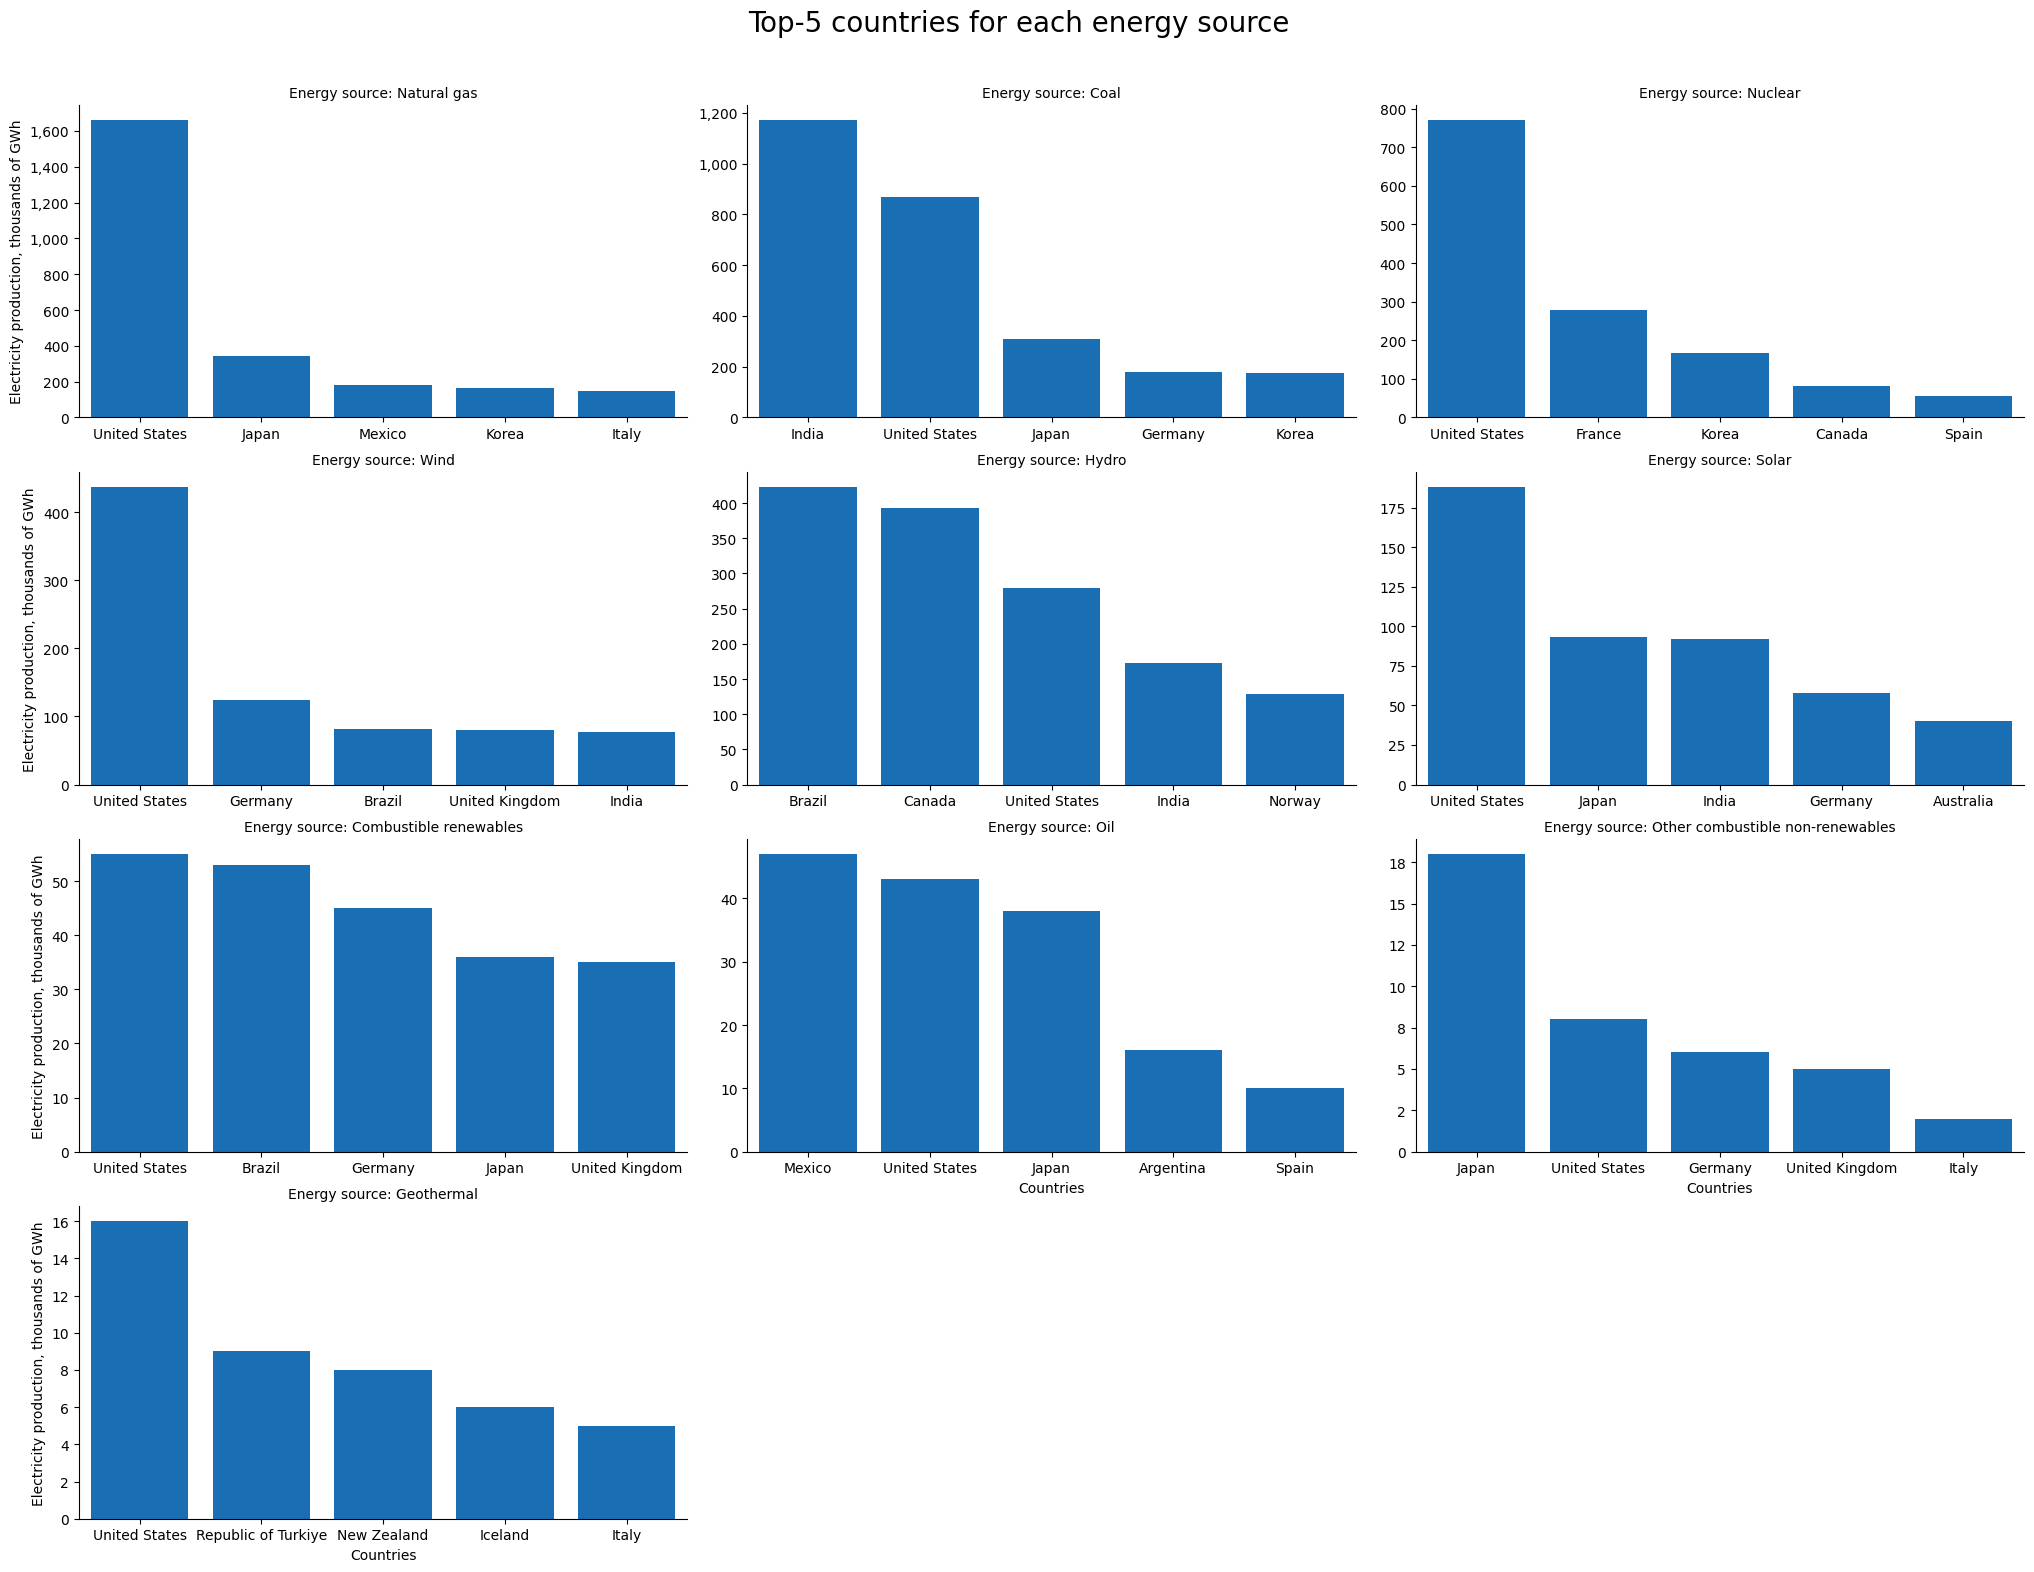

<Figure size 640x480 with 0 Axes>

In [298]:
# plot top-5 countries for each energy source
g = sns.catplot(data=countries_total_sources, x='country', y='total_thousands_gwh', col='energy_source', col_wrap=3, kind='bar',
                col_order=['Natural gas', 'Coal', 'Nuclear', 'Wind', 'Hydro', 'Solar', 'Combustible renewables', 'Oil',
                'Other combustible non-renewables', 'Geothermal'], 
                sharex=False, sharey=False, height=4, aspect=1.7, color='#0072CE')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Top-5 countries for each energy source', fontsize=20)
g.set_titles("Energy source: {col_name}")
g.set_axis_labels(x_var='Countries', y_var='Electricity production, thousands of GWh')
plt.show()
plt.clf()

<a id="eda_9"></a>

### 9. Is there a correlation between GDP per capita (in current US Dollars) and low-carbon electricity production share?

[(Back to Table of Contents)](#contents)

To investigate if there is a correlation between **_GDP per capita_** (in current US Dollars) and **_low-carbon electricity production share_** I obtained the most-up-to-date dataset with GDP per capita from [The World Bank website](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD) (latest available GDP data was for 2021). 

First graph shows *histograms* for share (%) of low-carbon electricity production and GDP per capita. The histogram for share (%) is multimodal with two distinctive picks ~36% and ~78%. The histogram for GDP is right-skewed with the majority of values concentrated around $30k.

Second graph shows *scatterplots* of the share of low-carbon electricity vs GDP per capita. We can see a moderate positive correlation between the two variables. Color coding of regions allows us to see that the countries with the highest GDP or the highest share of low-carbon electricity production are predominantly located in the **_OECD Europe region_**. 

To measure the correlation strength, I used `scipy.stats` to calculate Pearson correlation coefficient and p-value. *Pearson coefficient* was equal to *0.357*; as it is above 0.3 threshold we can say that there is **_moderate positive linear association between two variables_**. The *p-value* was equal to *0.014*; as it is below 0.05 threshold, we can say that **_the correlation is statistically significant_**.   

In [299]:
# calculate total low-carbon electricity production in 2021 for every country
countries_total_low_carbon_2021 = data_countries[(data_countries['year'] == 2021) & (data_countries['product'].\
                                  isin(low_carbon_generation_sources))]
countries_total_low_carbon_2021 = countries_total_low_carbon_2021.groupby('country')['value'].sum().round(0).reset_index()
countries_total_low_carbon_2021.columns = ['country', 'low_carbon_total']
countries_total_low_carbon_2021.head()

,country,low_carbon_total
0,Argentina,52811.0
1,Australia,79586.0
2,Austria,53473.0
3,Belgium,71184.0
4,Brazil,491566.0


In [300]:
# calculate total production in 2021 for every country and add it to countries_total_low_carbon_2021
countries_total_2021 = data_countries[data_countries['year'] == 2021].groupby('country')['value'].sum().round(0).reset_index()
countries_total_2021.columns = ['country', 'country_total']
countries_total_low_carbon_2021 = countries_total_low_carbon_2021.merge(countries_total_2021, how='left', on='country')
countries_total_low_carbon_2021.head()

,country,low_carbon_total,country_total
0,Argentina,52811.0,151548.0
1,Australia,79586.0,255974.0
2,Austria,53473.0,67225.0
3,Belgium,71184.0,95705.0
4,Brazil,491566.0,636952.0


In [301]:
# calculate share of low-carbon electricity production for every country
countries_total_low_carbon_2021['perc_low_carbon'] = round(countries_total_low_carbon_2021['low_carbon_total']/\
                                                     countries_total_low_carbon_2021['country_total']*100, 1)
# drop columns that won't be needed any more
countries_total_low_carbon_2021.drop(['low_carbon_total', 'country_total'], axis=1, inplace=True)
countries_total_low_carbon_2021.head()

,country,perc_low_carbon
0,Argentina,34.8
1,Australia,31.1
2,Austria,79.5
3,Belgium,74.4
4,Brazil,77.2


In [302]:
# load GDP data
data_gdp = pd.read_csv('gdp_pc_2021.csv')
# extract data for 2021 (latest data available)
data_gdp_2021 = data_gdp.drop(['Country Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2022'], axis=1)
# Rename columns and round data
data_gdp_2021.columns = ['country', 'gdp_per_capita']
data_gdp_2021['gdp_per_capita'] = data_gdp_2021['gdp_per_capita'].round(1)
data_gdp_2021.head()

,country,gdp_per_capita
0,Aruba,29342.1
1,Africa Eastern and Southern,1549.8
2,Afghanistan,368.8
3,Africa Western and Central,1757.0
4,Angola,1953.5


In [303]:
# add GDP info to countries_total_low_carbon_2021 df
countries_total_low_carbon_2021 = countries_total_low_carbon_2021.merge(data_gdp_2021, how='left', on='country')
# add region for every country
countries_total_low_carbon_2021['region'] = countries_total_low_carbon_2021['country'].apply(get_region)
countries_total_low_carbon_2021['region'].fillna('Non-OECD Economy', inplace=True)
countries_total_low_carbon_2021.head()

,country,perc_low_carbon,gdp_per_capita,region
0,Argentina,34.8,10636.1,Non-OECD Economy
1,Australia,31.1,60443.1,OECD Asia Oceania
2,Austria,79.5,53637.7,OECD Europe
3,Belgium,74.4,51247.0,OECD Europe
4,Brazil,77.2,7507.2,Non-OECD Economy


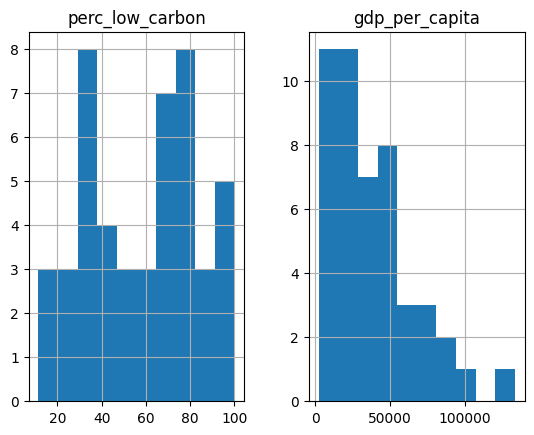

<Figure size 640x480 with 0 Axes>

In [304]:
# visualize distributions of low-carbon share and gdp
countries_total_low_carbon_2021.hist()
plt.show()
plt.clf()

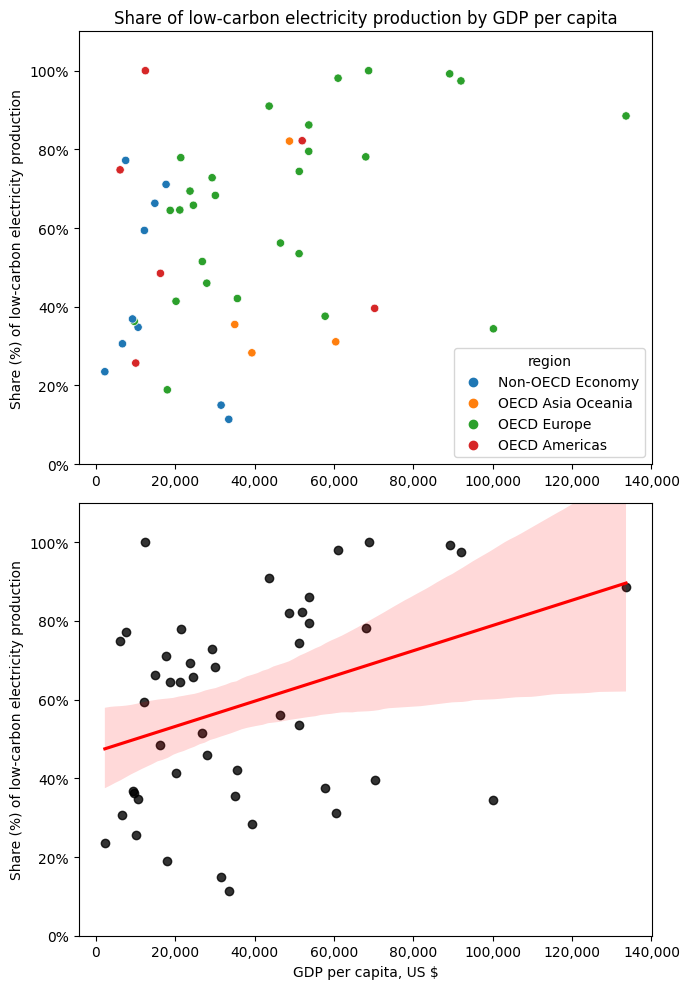

<Figure size 640x480 with 0 Axes>

In [305]:
# visualize relationship between GDP per capita and low-carbon rate
fig = plt.figure(figsize=(7, 10))
# regular scatterplot of gdp and low-carbon rate with color-coding for regions
ax1 = plt.subplot(2, 1, 1)
ax1 = sns.scatterplot(data=countries_total_low_carbon_2021, x='gdp_per_capita', y='perc_low_carbon', hue='region')
ax1.xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=0))
ax1.set_ylim(0, 110)
ax1.set(title='Share of low-carbon electricity production by GDP per capita',
        ylabel='Share (%) of low-carbon electricity production', xlabel=None)
# plot scatterplot with linear regression model
ax2 = plt.subplot(2, 1, 2)
ax2 = sns.regplot(data=countries_total_low_carbon_2021, x='gdp_per_capita', y='perc_low_carbon', scatter_kws={"color": "black"},
                  line_kws={"color": "red"})
ax2.xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=0))
ax2.set_ylim(0, 110)
ax2.set(xlabel='GDP per capita, US $', ylabel='Share (%) of low-carbon electricity production')
plt.tight_layout()
plt.show()
plt.clf()

In [306]:
# calculate Pearson correlation coefficient for GDP and low-carbon rate
corr_gdp_low_carbon_rate, p = pearsonr(countries_total_low_carbon_2021['gdp_per_capita'],
                                       countries_total_low_carbon_2021['perc_low_carbon'])
print(f"Pearson coefficient: {round(corr_gdp_low_carbon_rate, 3)}")
print(f"p-value: {round(p, 3)}")

Pearson coefficient: 0.357
p-value: 0.014


### 10. Distribution of low-carbon electricity production share by GDP quartiles <a id="eda_10"></a>

[(Back to Table of Contents)](#contents)

Regular approach by the World Bank is to classify countries by GDP per capita into four groups:
- Low income: with GDP per capita < 1,046 US Dollars
- Lower-middle income: GDP per capita between 1,046 and 4,095 in US Dollars
- Upper-middle income: GDP per capita between 4,096 and 12,695 US Dollars
- High income: with GDP per capita < 12,695 US Dollars

As can be seen below, this approach is not very helpful in our case as the majority of the countries in our dataset fall into *High income category* (37 out of 47) and *Upper-middle income category* (9 out of 47).

Better approach would be to categorize countries into *4 quartiles based on their GDP per capita value* and then plot boxplots of the low-carbon electricity production share for each GDP quartile.

As can be seen from the chart below, **_4th GDP quartile_** has the highest median share of low-carbon electricity production, which is actually higher than the 75 percentile for other GDP quartiles. This correlates with our findings in the previous question where we discovered moderate positive correlation between these two variables. This GDP quartile also has the largest interquartile range, indicating that there is a higher difference in the share of low-carbon electricity production between countries in this GDP quartile. Surprisingly, the median share of low-carbon electricity production for **_2nd GDP quartile_** is significantly higher than for the **_3rd GDP quartile_**, but 75 percentile is significantly below. **_2nd GDP quartile_** also has the smallest interquartile range, which shows that there is a smaller difference in the low-carbon share between countries in this GDP quartile. **_2nd GDP quartile_** is the only quartile that has an outlier - Poland with the 18.9% share of low-carbon electricity production, significantly below other countries in this quartile.

In [307]:
# classify countries by GDP per capita according to the World Bank classification
conditions = [
    countries_total_low_carbon_2021['gdp_per_capita'].lt(1046),
    countries_total_low_carbon_2021['gdp_per_capita'].ge(1046) & countries_total_low_carbon_2021['gdp_per_capita'].le(4095),
    countries_total_low_carbon_2021['gdp_per_capita'].ge(4096) &\
        countries_total_low_carbon_2021['gdp_per_capita'].le(12695),
    countries_total_low_carbon_2021['gdp_per_capita'].gt(12695)
]

choices = [
    'low income',
    'lower-middle income',
    'upper-middle income',
    'high income'
]

countries_total_low_carbon_2021['gdp_classification'] = np.select(conditions, choices)

In [308]:
# count number of countries in each World Bank's category
countries_gdp_classif_2021 = countries_total_low_carbon_2021.groupby('gdp_classification')['country'].count().\
                                    sort_values(ascending=False).reset_index()
countries_gdp_classif_2021.columns = ['gdp_classification', 'count']
countries_gdp_classif_2021


,gdp_classification,count
0,high income,37
1,upper-middle income,9
2,lower-middle income,1


In [309]:
# categorize countries into quartiles based on GDP per capita
countries_total_low_carbon_2021['gdp_quartiles'] = pd.qcut(x=countries_total_low_carbon_2021['gdp_per_capita'],
    q=[0, 0.25, 0.5, 0.75, 1], labels=['1st quartile', '2nd quartile', '3rd quartile', '4th quartile'])
countries_total_low_carbon_2021.head(5)

,country,perc_low_carbon,gdp_per_capita,region,gdp_classification,gdp_quartiles
0,Argentina,34.8,10636.1,Non-OECD Economy,upper-middle income,1st quartile
1,Australia,31.1,60443.1,OECD Asia Oceania,high income,4th quartile
2,Austria,79.5,53637.7,OECD Europe,high income,4th quartile
3,Belgium,74.4,51247.0,OECD Europe,high income,3rd quartile
4,Brazil,77.2,7507.2,Non-OECD Economy,upper-middle income,1st quartile


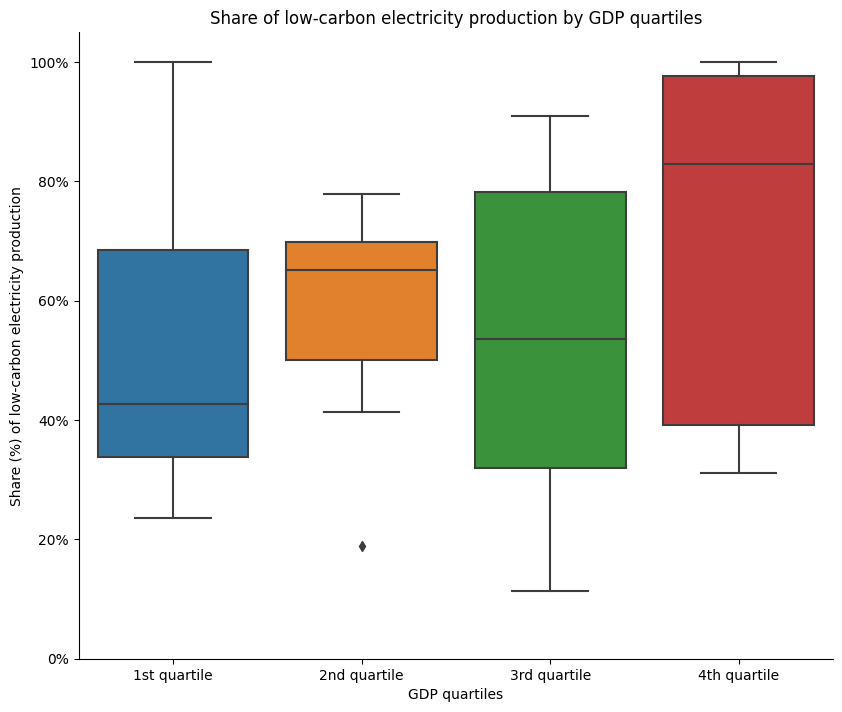

<Figure size 640x480 with 0 Axes>

In [310]:
# visualize distribution of low-carbon share for each gdp quartile using boxplots
g = sns.catplot(data=countries_total_low_carbon_2021, x='gdp_quartiles', y='perc_low_carbon', kind='box', height=7, aspect=1.2)
g.ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(decimals=0))
g.ax.set_ylim(0, 105)
g.ax.set(title='Share of low-carbon electricity production by GDP quartiles', xlabel='GDP quartiles',
         ylabel='Share (%) of low-carbon electricity production')
plt.show()
plt.clf()


## Conclusion <a id="conclusion"></a>

[(Back to Table of Contents)](#contents)

The analysis showed that **_total electricity production_** for all OECD countries had a moderate growth 2010-2022 period and only increased by 3.6% if compared with 2010 level. However the **_total low-carbon electricity production_** increased significantly: 26.4% jump if compared with 2010 level. 

This is also reflected in the **_proportions for energy sources_** in 2022 - when compared with 2010 level, *Coal* share dropped -14.2%, *Wind* share jumped 7.5% and *Solar* share jumped 5.4%.

We also discovered distinctive **_seasonality_** in *monthly electricity production in OECD countries* with sharp increases in Dec-Jan and Jul-Aug periods and distinctive declines in Apr-May and Oct-Nov periods consistently every year.

In 2022 in **_OECD Americas region_** such low-carbon energy sources as *Nuclear*, *Hydro* and *Wind* took 3-rd, 4th and 5th places by total electricity generated. In **_OECD Europe region_** low-carbon energy sources had even higher ranking - *Nuclear*, *Wind* and *Hydro* were on 2nd, 3rd and 4th places by total electricity generated. In **_OECD Asia Oceania region_** *Nuclear*, *Solar* and *Hydro* took 3-rd, 4th and 5th places by total electricity generated.

The **_proportion of low-carbon power generation_** throughout the whole period was highest in *OECD Europe region* and lowest in *OECD Asia Oceania region*. *OECD Asia Oceania region* experienced a very significant drop in low-carbon electricity generation in 2011-2012. As further investigation showed, this was largely due to March 2011 nuclear accident at the Fukushima Daiichi Nuclear Power Plant in Japan caused by the earthquake and tsunami, subsequent shut-down of nuclear reactors and sharp increases in *Natural gas* and *Oil* generations to compensate for the *Nuclear* generation drop.

Among all countries in 2022, **_the United states_** was the biggest electricity producer, with **_India_** and **_Japan_** on 2nd and 3rd places respectively. When considering energy sources separately, for *Natural gas*, *Nuclear*, *Wind*, *Solar*, *Combustible renewables* and *Geothermal energy* sources **_the United states_** generated the highest amount of electricity from them. **_India_** was the country that generated the largest amount of electricity using *Coal*; **_Brazil_** - using *Hydro*, **_Mexico_** - using *Oil*, **_Japan_** - using *Other combustible non-renewables*.

Analysis also showed that there was **_moderate positive correlation_** between *GDP per capita* (in current US Dollars) and *low-carbon electricity production share*.
           